In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz, plot_tree, export_text
from src.visualization.visualize import plot_confusion_matrix, plot_grid_search
from src.model_evaluation.param_analysis import grid_search_df, evaluate_parameter
from src.model_evaluation.resampling import bias_var, bias_var_analysis
from sklearn.metrics import precision_score,f1_score,recall_score,balanced_accuracy_score, confusion_matrix,precision_recall_fscore_support,accuracy_score
from src.model_evaluation.metrics import scores
from IPython.display import display
from imblearn.over_sampling import SMOTE
import sys
import xgboost as xgb
sns.set_theme()

# Data preprocessing
First we load the data set for inspection

In [2]:
manufacturing = pd.read_csv('data/raw/predictive_maintenance.csv')
manufacturing.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [3]:
manufacturing.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


As can be seen, there are 10000 non-null counts on every column. Additionally, the dtypes seems correctly defined.
Column 'UDI' and 'Product ID' are unique for each sample and should therefore be removed as they'll not provide any information to the model.

In [4]:
manufacturing.drop(['UDI','Product ID'],axis=1,inplace=True)
manufacturing.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


In [5]:
X = manufacturing.iloc[:,:6] #Features are columns 0 through 5. Avoid using target here
X

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,M,298.1,308.6,1551,42.8,0
1,L,298.2,308.7,1408,46.3,3
2,L,298.1,308.5,1498,49.4,5
3,L,298.2,308.6,1433,39.5,7
4,L,298.2,308.7,1408,40.0,9
...,...,...,...,...,...,...
9995,M,298.8,308.4,1604,29.5,14
9996,H,298.9,308.4,1632,31.8,17
9997,M,299.0,308.6,1645,33.4,22
9998,H,299.0,308.7,1408,48.5,25


Here 'X' is the feature matrix. It contains 6 features.\
Also there is a categorical column in the data set, namely 'Type'. There are three categories of this feature\
L - Low\
M - Medium\
H - High\
and they denote the quality of the product produced. Higher quality likely means more work and possibly more wear on the tools. From this, it seems clear that decision trees or ensemble methods using decision trees should be employed.\
These categories should be binarized.

In [6]:
type =pd.get_dummies(X['Type']) #Converts categorical data into indicator variables
X = pd.concat([X,type],axis=1) #Add back into feature matrix
X.drop('Type',axis=1,inplace=True) #Drop type column as it's no longer needed
X

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],H,L,M
0,298.1,308.6,1551,42.8,0,0,0,1
1,298.2,308.7,1408,46.3,3,0,1,0
2,298.1,308.5,1498,49.4,5,0,1,0
3,298.2,308.6,1433,39.5,7,0,1,0
4,298.2,308.7,1408,40.0,9,0,1,0
...,...,...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,0,0,1
9996,298.9,308.4,1632,31.8,17,1,0,0
9997,299.0,308.6,1645,33.4,22,0,0,1
9998,299.0,308.7,1408,48.5,25,1,0,0


In [7]:
#The classes are columns 7 and rest
y_m = manufacturing.iloc[:,7]
y_m.value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

'Target' describe if any of the failure types has occured. In other words, there are two possible ways to solve this. Binary classification, where 'Target' is the target data with class 0 and 1. And multiclass where the labes/classes are those printed out above.\
0: NF - No failure\
1: HDF - Heat Dissipation Failure\
2: PWF - Power Failure\
3: OSF - Overstrain Failure\
4: TWF - Tool Wear Failure\
5: RNF - Random Failrues

In [8]:
y_b = manufacturing.iloc[:,6:7] #Failure or not(binary classification) is column 6
y_b.value_counts()

Target
0         9661
1          339
dtype: int64

As can be seen, there are not a whole lot of failures compared to non-failure samples. And so the dataset is biased towards non-failures. In other words, the model will train on a lot more samples where no failures occur than the opposite. If the model ends up guessing only no machine failures, then it will still achieve quite a good score. It is unclear if this is good or bad for the model at this moment. However, one must look at the amount of failures both in train and test to assess if it's any better than only guessing "no failure".

This small interval of actual performance can make it hard to evaluate real performance. And as such, one should focus on metrics that better captures this.

With such a small amount of Random Failure, one can suspect the model guess worse on this. Random Failures is perhaps not equally important as it doesn't help you stock up in advance on a certain part for instance. The low amount of Tool Wear Failure might be problematic though.

<AxesSubplot:>

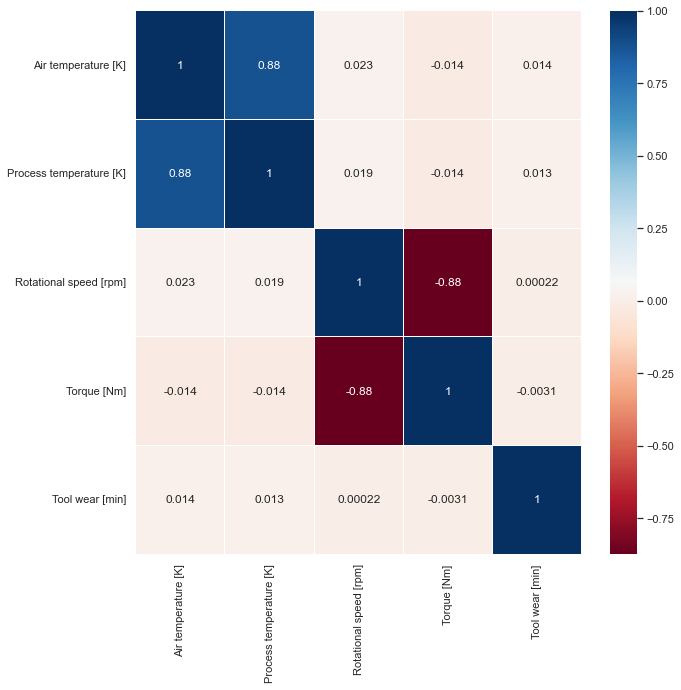

In [9]:
fig, ax1 = plt.subplots(figsize=(10,10))
sns.heatmap(X.iloc[:,:5].corr(),cmap='RdBu',annot = True,linewidths=0.01,linecolor='white')

The correlations are more or less maintained after oversampling, however some of the smaller correlations has changed somewhat.

In [ ]:
manufacturing['Type'].value_counts()

<AxesSubplot:>

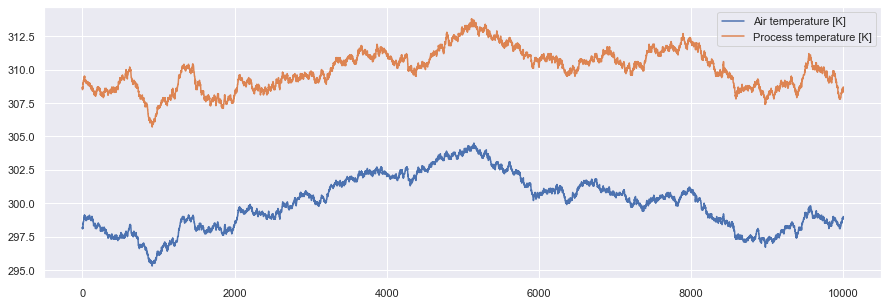

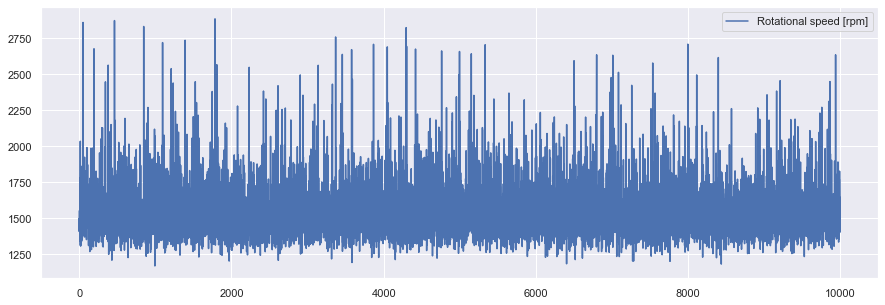

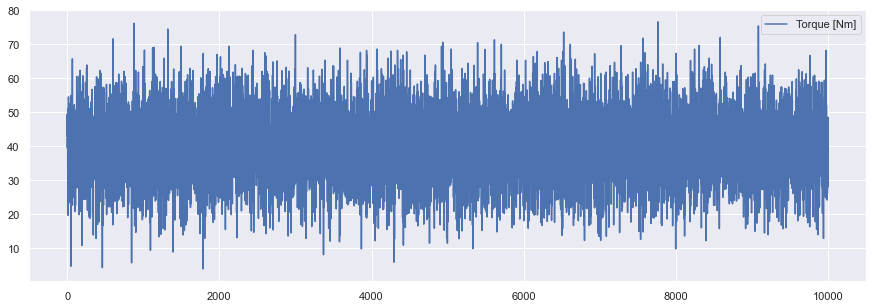

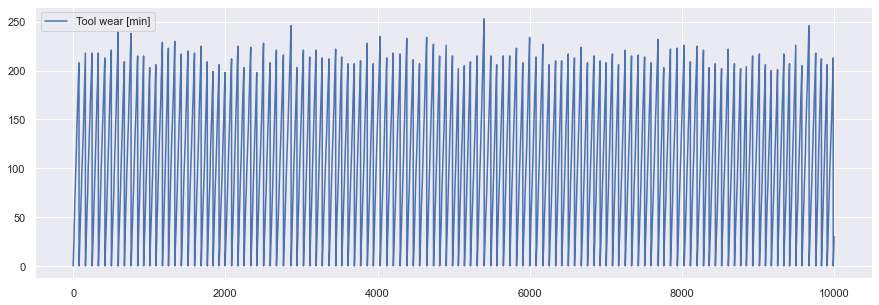

In [10]:
fig, ax1 = plt.subplots(figsize=(15,5))
X.iloc[:,:2].plot(ax=ax1)
fig, ax1 = plt.subplots(figsize=(15,5))
X.iloc[:,2:3].plot(ax=ax1)
fig, ax1 = plt.subplots(figsize=(15,5))
X.iloc[:,3:4].plot(ax=ax1)
fig, ax1 = plt.subplots(figsize=(15,5))
X.iloc[:,4:5].plot(ax=ax1)


There is a clear correlation bewteen air temperature and process temperature, which indeed makes sense. Furthermore the rotational speed and the torque is and should also correlate. One thing to consider is whether they correlate too much, thereby not adding anything to the model.

Splitting the data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y_m, random_state=1)
print('Train')
display(y_train.value_counts())
print('\nTest')
display(y_test.value_counts())

Train


No Failure                  7245
Heat Dissipation Failure      86
Power Failure                 64
Overstrain Failure            57
Tool Wear Failure             35
Random Failures               13
Name: Failure Type, dtype: int64


Test


No Failure                  2407
Power Failure                 31
Heat Dissipation Failure      26
Overstrain Failure            21
Tool Wear Failure             10
Random Failures                5
Name: Failure Type, dtype: int64

Note that a test size of 0.25 is chosen by default, and that all classes are split evenly. That is, it's more or less the same distribution in train and test set.

# Modeling

## Decision tree
A simple decision tree will low depth will first be tested to assess the results.

Train data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,0.000000,0.000000,0.000000,0.000000,86.0
No Failure,0.999862,0.973787,0.999862,0.986652,7245.0
Overstrain Failure,0.157895,0.692308,0.157895,0.257143,57.0
Power Failure,0.734375,0.979167,0.734375,0.839286,64.0
Random Failures,0.000000,0.000000,0.000000,0.000000,13.0
Tool Wear Failure,0.000000,0.000000,0.000000,0.000000,35.0
Macro averaged,0.315355,0.440877,0.315355,0.347180,None
Micro averaged,0.973333,0.973333,0.973333,0.973333,None



Test data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,0.000000,0.000000,0.000000,0.000000,26.0
No Failure,0.998754,0.971706,0.998754,0.985044,2407.0
Overstrain Failure,0.047619,0.200000,0.047619,0.076923,21.0
Power Failure,0.645161,0.952381,0.645161,0.769231,31.0
Random Failures,0.000000,0.000000,0.000000,0.000000,5.0
Tool Wear Failure,0.000000,0.000000,0.000000,0.000000,10.0
Macro averaged,0.281922,0.354014,0.281922,0.305200,None
Micro averaged,0.970000,0.970000,0.970000,0.970000,None


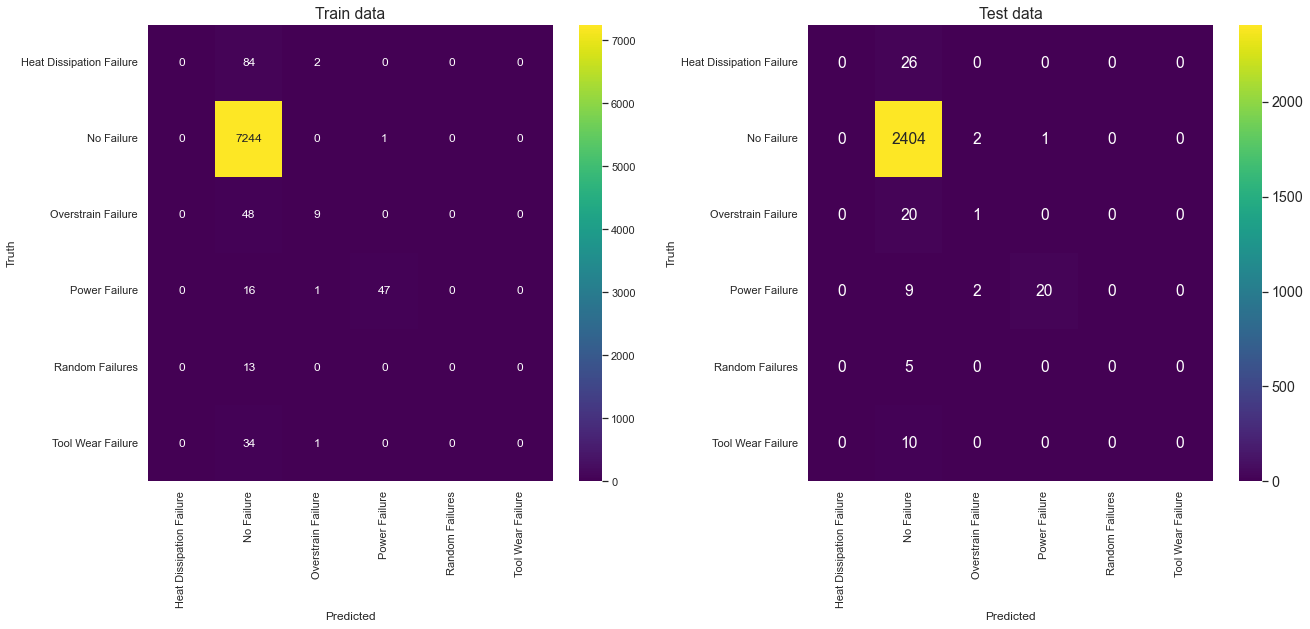

In [12]:
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X_train, y_train)

export_graphviz(
    clf,
    out_file="man.dot",
    feature_names=X.columns,
    #class_names=['no failure','failure'],
    class_names=clf.classes_,
    rounded=True,
    filled=True
)
cmd = 'dot -Tpng man.dot -o decisiontree1.png'
os.system(cmd)

y_tilde = clf.predict(X_train)
y_pred =clf.predict(X_test)

#Confusion matrix
cm_train = confusion_matrix(y_train, y_tilde)
cm_test = confusion_matrix(y_test, y_pred)
indexes = np.append(clf.classes_,['Macro averaged','Micro averaged'])
metrics = ['Accuracy','Precision','Recall','F1-score','Support(n samples)']
#Display the scores
print("Train data")
display(scores(y_train,y_tilde,indexes,metrics))
print("\nTest data")
display(scores(y_test,y_pred,indexes,metrics))
#Plotting the confusion matrices
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
fig.tight_layout()
fig.tight_layout(pad=10.0)
ax1 = plot_confusion_matrix(conf_mat = cm_train,ax=ax1,title = 'Train data',labels=clf.classes_)
ax2 = plot_confusion_matrix(conf_mat = cm_test,ax=ax2,title = 'Test data',labels=clf.classes_)

Obtained accuracy of 0.97 is quite bad given that guessing only "No failures" would give you almost the same result. From the confusion matrix it can be seen that it almost only guessed "No Failures" as well, indicating that the imbalance in the data set makes it hard for the model to learn the other patterns. This is more clear from the macro averaged scores.

The tree seem to predict a lot of the non-failures as random failures. This does indeed make sense as the randomness makes it hard to find patterns. So when random failures are oversampled, a lot of failures with no real pattern between are created and so becomes hard to predict correctly. The model might be too biased towards random failures, and it is perhaps futile to balance the data set towards it.

Deeper trees with and without pruning will be tested before continuing with Bagging, Random Forest, Boosting and Gradient Boosting.

{'ccp_alpha': 1e-05, 'max_depth': 14}


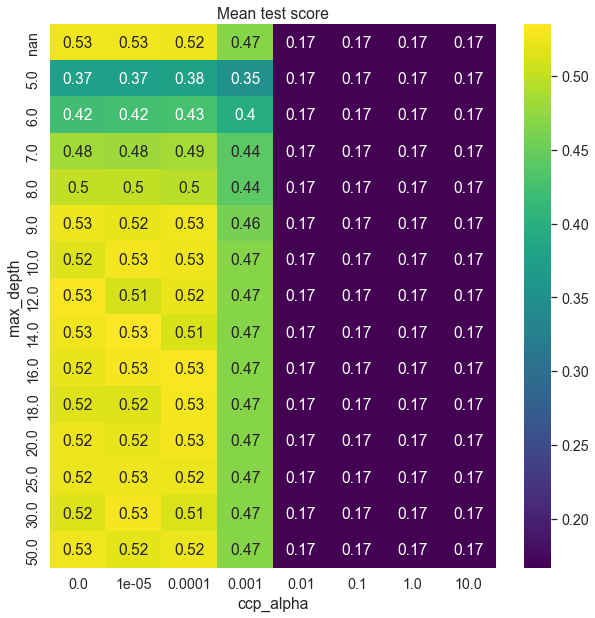

In [18]:
clf = DecisionTreeClassifier()
depths = [5,6,7,8,9,10,12,14,16,18,20,25,30,50,None]
pruning = [0,0.00001,0.0001,0.001,0.01,0.1,1,10]
params = {'max_depth':depths,'ccp_alpha':pruning}
gs, res = grid_search_df(X_train,y_train,clf,params,'balanced_accuracy')
print(gs.best_params_)
plot_grid_search(res,('max_depth','ccp_alpha'))

From the above plotted gridsearch it seems that the tree does not severly overfit when growing larger. Pruning does not seem to make the model more general. After depth 12 it seems the model is not improving. It might be due to a non-improving gini. The pruning does not seem to take any real effect before 0.001.

In [16]:
clf= DecisionTreeClassifier(max_depth=50,ccp_alpha=0).fit(X_train,y_train)
print("Depth: ",clf.get_depth())
print("Number of nodes: ",clf.tree_.node_count)
print('\n')

clf= DecisionTreeClassifier(max_depth=50,ccp_alpha=0.00001).fit(X_train,y_train)
print("Depth: ",clf.get_depth())
print("Number of nodes: ",clf.tree_.node_count)
print('\n')

clf= DecisionTreeClassifier(max_depth=50,ccp_alpha=0.0001).fit(X_train,y_train)
print("Depth: ",clf.get_depth())
print("Number of nodes: ",clf.tree_.node_count)

Depth:  20
Number of nodes:  325


Depth:  20
Number of nodes:  325


Depth:  20
Number of nodes:  263


Note that ccp_alpha of 0.00001 does not seem to affect the number of nodes in the tree and so is equivalent of no pruning. ccp_alpha = 0.0001 does however reduce the number of leaves somewhat which can be seen by the sligth decrease in performance as well.

As can be seen, the algorithm stops at depth 20, with a train accuracy of 1. As such, the model has been able to reach a zero gini factor on each leaf thereby reaching a saturation of test score. It may seem that a simple decision tree is not able to generalize from the train data, even if the depth is higher with or without pruning. Depth 14 with no pruning is chosen going foward.

Train data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,1.000000,1.000000,1.000000,1.000000,86.0
No Failure,1.000000,0.997934,1.000000,0.998966,7245.0
Overstrain Failure,1.000000,1.000000,1.000000,1.000000,57.0
Power Failure,1.000000,1.000000,1.000000,1.000000,64.0
Random Failures,0.461538,1.000000,0.461538,0.631579,13.0
Tool Wear Failure,0.771429,1.000000,0.771429,0.870968,35.0
Macro averaged,0.872161,0.999656,0.872161,0.916919,None
Micro averaged,0.998000,0.998000,0.998000,0.998000,None



Test data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,0.769231,0.740741,0.769231,0.754717,26.0
No Failure,0.991275,0.987992,0.991275,0.989631,2407.0
Overstrain Failure,0.619048,0.684211,0.619048,0.650000,21.0
Power Failure,0.774194,0.960000,0.774194,0.857143,31.0
Random Failures,0.000000,0.000000,0.000000,0.000000,5.0
Tool Wear Failure,0.200000,0.166667,0.200000,0.181818,10.0
Macro averaged,0.558958,0.589935,0.558958,0.572218,None
Micro averaged,0.978000,0.978000,0.978000,0.978000,None


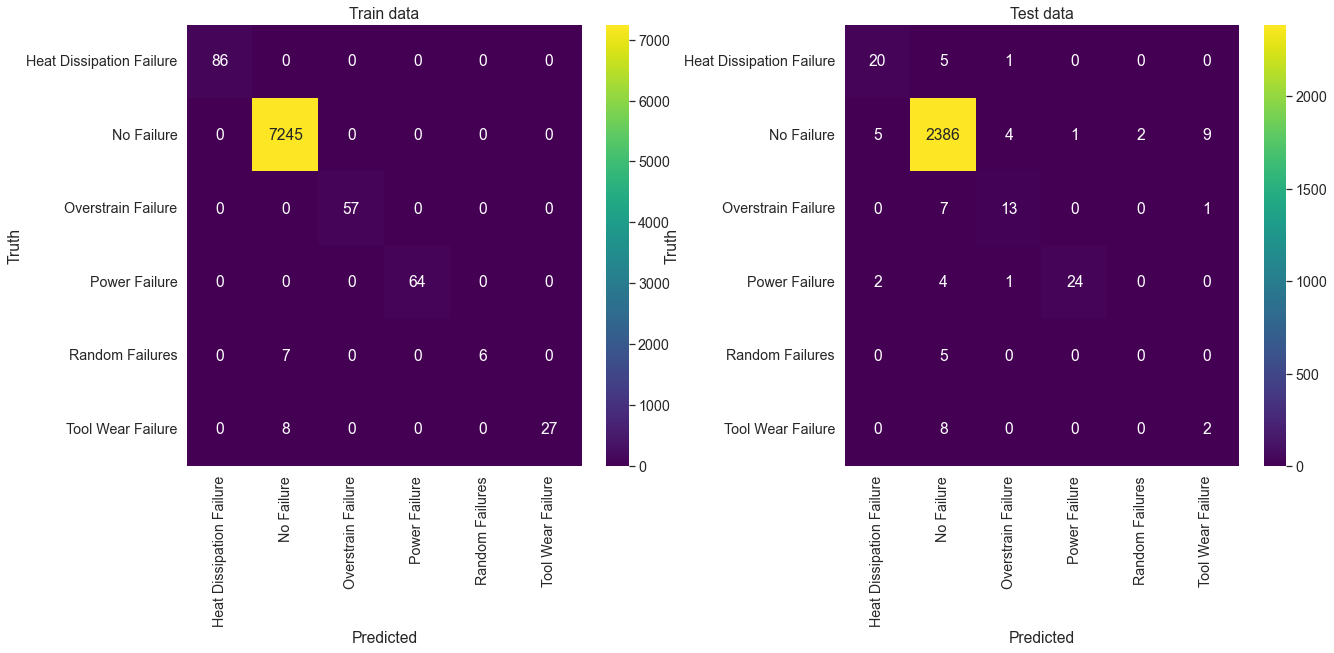

In [118]:
clf = DecisionTreeClassifier(max_depth=14).fit(X_train,y_train)
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
fig.tight_layout()
fig.tight_layout(pad=8.0)

ax1 = plot_confusion_matrix(y_train,clf.predict(X_train),ax=ax1,title = 'Train data',labels=clf.classes_)
ax2 = plot_confusion_matrix(y_test,clf.predict(X_test),ax=ax2,title = 'Test data',labels=clf.classes_)

y_tilde = clf.predict(X_train)
y_pred =clf.predict(X_test)

#Confusion matrix
cm_train = confusion_matrix(y_train, y_tilde)
cm_test = confusion_matrix(y_test, y_pred)
indexes = np.append(clf.classes_,['Macro averaged','Micro averaged'])
metrics = ['Accuracy','Precision','Recall','F1-score','Support(n samples)']
#Display the scores
print("Train data")
display(scores(y_train,y_tilde,indexes,metrics))
print("\nTest data")
display(scores(y_test,y_pred,indexes,metrics))

In [145]:
indexes = ['HDF','NF','OF','PF','RF','TWF','Macro avg','Micro avg']
df = scores(y_test,y_pred,indexes,metrics).astype(float).round(2)
df.index = indexes

print(df.to_latex(columns=['Accuracy','Precision','Recall','F1-score']))


\begin{tabular}{lrrrr}
\toprule
{} &  Accuracy &  Precision &  Recall &  F1-score \\
\midrule
HDF       &      0.88 &       0.92 &    0.88 &      0.90 \\
NF        &      1.00 &       0.99 &    1.00 &      0.99 \\
OF        &      0.71 &       0.83 &    0.71 &      0.77 \\
PF        &      0.71 &       0.92 &    0.71 &      0.80 \\
RF        &      0.00 &       0.00 &    0.00 &      0.00 \\
TWF       &      0.00 &       0.00 &    0.00 &      0.00 \\
Macro avg &      0.55 &       0.61 &    0.55 &      0.58 \\
Micro avg &      0.98 &       0.98 &    0.98 &      0.98 \\
\bottomrule
\end{tabular}



In [131]:
scores(y_train,y_tilde,indexes,metrics).astype(float).round(3)

,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,1.000,1.000,1.000,1.000,86.0
No Failure,1.000,0.998,1.000,0.999,7245.0
Overstrain Failure,1.000,1.000,1.000,1.000,57.0
Power Failure,1.000,1.000,1.000,1.000,64.0
Random Failures,0.462,1.000,0.462,0.632,13.0
Tool Wear Failure,0.771,1.000,0.771,0.871,35.0
Macro averaged,0.872,1.000,0.872,0.917,NaN
Micro averaged,0.998,0.998,0.998,0.998,NaN


With a perfect score on the train set and a low score on the test data, the tree might be overfitting. However it is perhaps more likely that a decision tree is not able to generalize enough with the given data set due to its high variance.

<AxesSubplot:title={'center':'Macro averaged Precision for Train and Test'}, xlabel='max_depth', ylabel='Precision'>

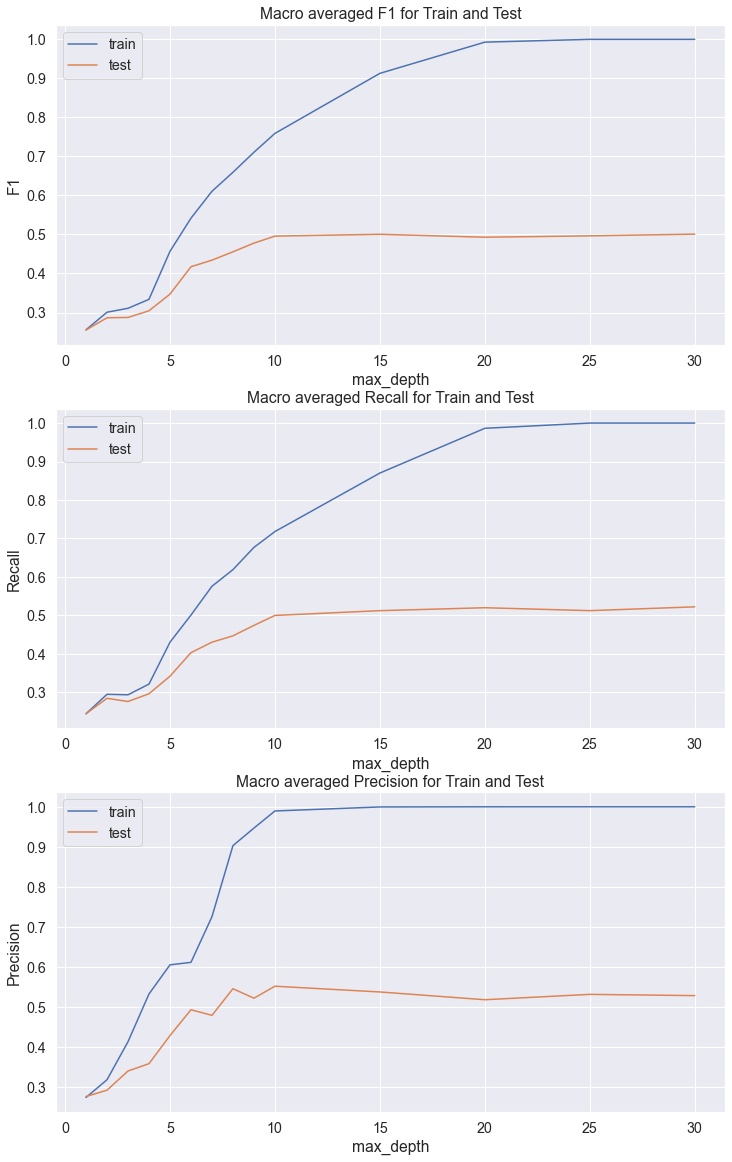

In [39]:
clf = DecisionTreeClassifier()
depths = np.asarray([1,2,3,4,5,6,7,8,9,10,15,20,25,30],dtype=int)
params = {'max_depth':depths}
score_dict = evaluate_parameter(clf, params, ['f1','recall','precision'], X, y_m)

#Plotting
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (12,20))
pd.DataFrame(score_dict['f1'],index = depths).plot(xlabel='max_depth',
                                                   ylabel='F1',
                                                   title='Macro averaged F1 for Train and Test',
                                                   ax=ax1)
pd.DataFrame(score_dict['recall'],index = depths).plot(xlabel='max_depth',
                                                       ylabel='Recall',
                                                       title='Macro averaged Recall for Train and Test',
                                                       ax=ax2)
pd.DataFrame(score_dict['precision'],index = depths).plot(xlabel='max_depth',
                                                          ylabel='Precision',
                                                          title='Macro averaged Precision for Train and Test',
                                                          ax=ax3)

In [40]:
depths[np.argmax(score_dict['f1']['test'])]

30

As can be seen the test scores seem to stagnate at about depth 6 while the train scores increases. This is the case for all metrics. After depth 6 they all seem to decrease slightly after which they increase again at depth 30. This might indicate a slight overfit, however very small. Since the maximum possible depths for the tree(given no max depth) the test f1-score is still saturated at about 0.55 and not decreasing substantially as one would expect with a too large tree. It may show that on this data set a fully grown tree simply does not overfit as much.

A bias variance decomposition is conducted using a naive squared error approach. The error, bias and variance are calculated for every class for all choices of tree depth and may then either be aggregated or presented individually.

<AxesSubplot:title={'center':'Variance'}>

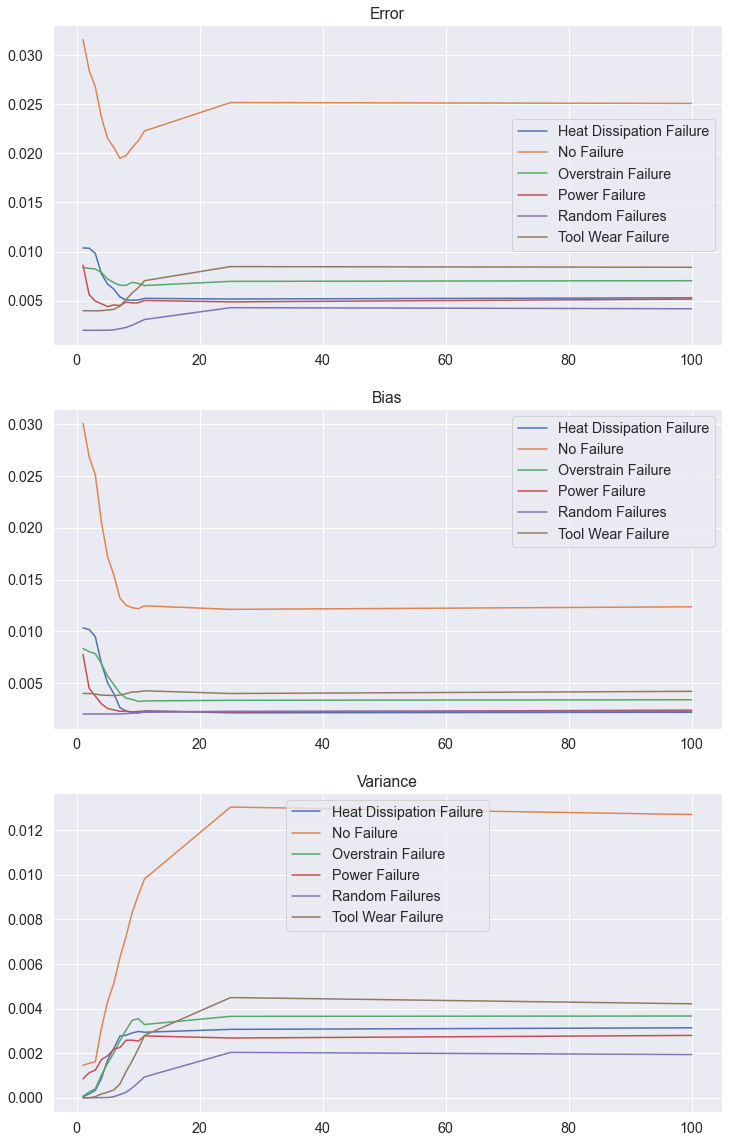

In [41]:
#Tree depths to test
complexity = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,25,100]}
#Calculating bias variance on all complexity params
err,bi,var = bias_var_analysis(clf,X_train, X_test, y_train,y_test,complexity,100)
#Creating data frames
err_df = pd.DataFrame(err,columns=clf.classes_,index=list(complexity.values())[0])
bi_df = pd.DataFrame(bi,columns=clf.classes_,index=list(complexity.values())[0])
var_df = pd.DataFrame(var,columns=clf.classes_,index=list(complexity.values())[0])
#Plotting
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (12,20))
err_df.plot(title='Error',ax=ax1)
bi_df.plot(title='Bias',ax=ax2)
var_df.plot(title='Variance',ax=ax3)

Note that all measures are larger for No Failure class, which indeed makes sense as there are a lot more of them. If the model always guesses negative on random failures, that will still lead to a very low error since there are so few positives of it. If we were to normalize the measures in terms of the sample count for each class it is likely that they would have been closer.

The plots does show that the variance is steadily increasing with increased depth, up untill about 25. This does indeed make sense, as increased complexity may lead to increased caruance. Furthermore it is around 25 that the tree is not able to grow larger thereby not becoming more complex. 

<AxesSubplot:title={'center':'Bias Variance for complete model'}>

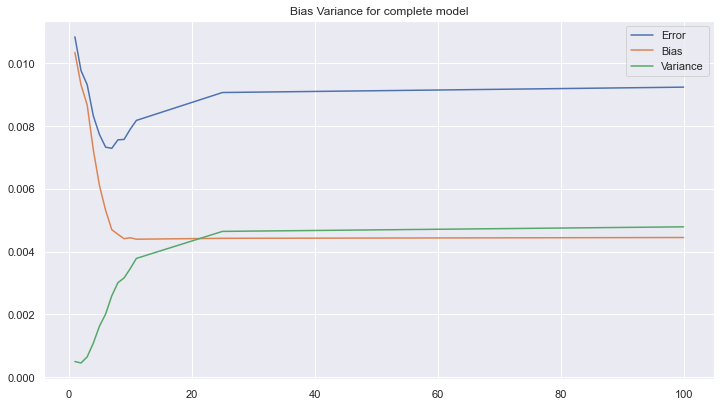

In [258]:
fig, ax1 = plt.subplots(1,1,figsize = (12,6.6))
pd.DataFrame(np.column_stack([np.mean(err,axis=1),np.mean(bi,axis=1),np.mean(var,axis=1)]),
             columns=['Error','Bias','Variance'],
             index=list(complexity.values())[0]).plot(title='Bias Variance for complete model',ax=ax1)

In [42]:
np.argmin(np.mean(err,axis=1))

6

Aggregating for all classes, we see that the variance surpasses the bias at about depth 21. This may indicate a slight overfit as stated above. The bias on the other hand does not continue to decrease after about depth 10. The lowest MSE seem to be at depth 6. Note that the MSE is not a good loss for multiclass, and one should perhaps not base decisions on that. However, above plot shows how the depth of the decision tree affects these measures.

A conclusion may be that the maximum possible depth of this tree given the features and the data set only leads to a slight overfit.
### Benchmarking Decision Tree
For benchmarking F1, recall and precision will be cross validated. Most emphasis will be put on F1 however all will be discussed.

A depth of 15 is used here as it is still somewhat conservative while achieve good score.

In [43]:
from sklearn.model_selection import StratifiedKFold
#Must use a stratified kfold due to class imbalance
cvs = StratifiedKFold(shuffle=True,n_splits=4)
clf = DecisionTreeClassifier(max_depth=15)
#Cross validating f1 score
dt1_f1 = np.mean(cross_val_score(clf,X,y_m,scoring='f1_macro',n_jobs=-1,cv=cvs))
dt1_recall = np.mean(cross_val_score(clf,X,y_m,scoring='recall_macro',n_jobs=-1,cv=cvs))
dt1_precision = np.mean(cross_val_score(clf,X,y_m,scoring='precision_macro',n_jobs=-1,cv=cvs))
print('Cross validated F1 score: \t\t',dt1_f1)
print('Cross validated recall score: \t\t',dt1_recall)
print('Cross validated precision score: \t',dt1_precision)

Cross validated F1 score: 		 0.5487697487937809
Cross validated recall score: 		 0.5422110176503837
Cross validated precision score: 	 0.5535600495147427


In any case, the test score obtained is not very impressive and it seem to never being fully able to generalize. This might be due to the sparsity of most other classes than "No Failure".

As such, SMOTE method can be used to oversample the data, i.e reduce the balance. SMOTE uses k-nearest neighbours to generate synthetic samples of the minority classes. By first splitting the data, and then oversampling(i.e. generating sythetic samples) only on the train set, one can then run the test on a more real life scenario where there's actually a lot more of the "No Failure" class. This will not be done in this analysis, however can be an item of improvement for the next project.

In [104]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=42)
X_ovs,y_ovs=smote.fit_resample(X,y_m)
X_train_ovs, X_test_ovs, y_train_ovs, y_test_ovs = train_test_split(X_ovs, y_ovs, random_state=1)

In [181]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer().fit(y_m.to_numpy().reshape(-1,1))
enc.transform(y_test.to_numpy().reshape(-1,1)).shape

(2500, 6)

To demonstrate the bias-variance tade-off, the binary classification case is considere. Here the mean squared error is used to measure the error between predicted probability and actual class. A simple implementation to this that is sufficient for demonstration is to use the same output predictions, and sum probabilities of all other classes than "No failure". It must be said that the model might yield a different solution if trained directly on binary classification instead.

## Bagging

Train data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,1.0,1.0,1.0,1.0,86.0
No Failure,1.0,1.0,1.0,1.0,7245.0
Overstrain Failure,1.0,1.0,1.0,1.0,57.0
Power Failure,1.0,1.0,1.0,1.0,64.0
Random Failures,1.0,1.0,1.0,1.0,13.0
Tool Wear Failure,1.0,1.0,1.0,1.0,35.0
Macro averaged,1.0,1.0,1.0,1.0,None
Micro averaged,1.0,1.0,1.0,1.0,None



Test data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,0.884615,0.958333,0.884615,0.920000,26.0
No Failure,0.999169,0.987274,0.999169,0.993186,2407.0
Overstrain Failure,0.523810,0.916667,0.523810,0.666667,21.0
Power Failure,0.870968,0.964286,0.870968,0.915254,31.0
Random Failures,0.000000,0.000000,0.000000,0.000000,5.0
Tool Wear Failure,0.000000,0.000000,0.000000,0.000000,10.0
Macro averaged,0.546427,0.637760,0.546427,0.582518,None
Micro averaged,0.986400,0.986400,0.986400,0.986400,None


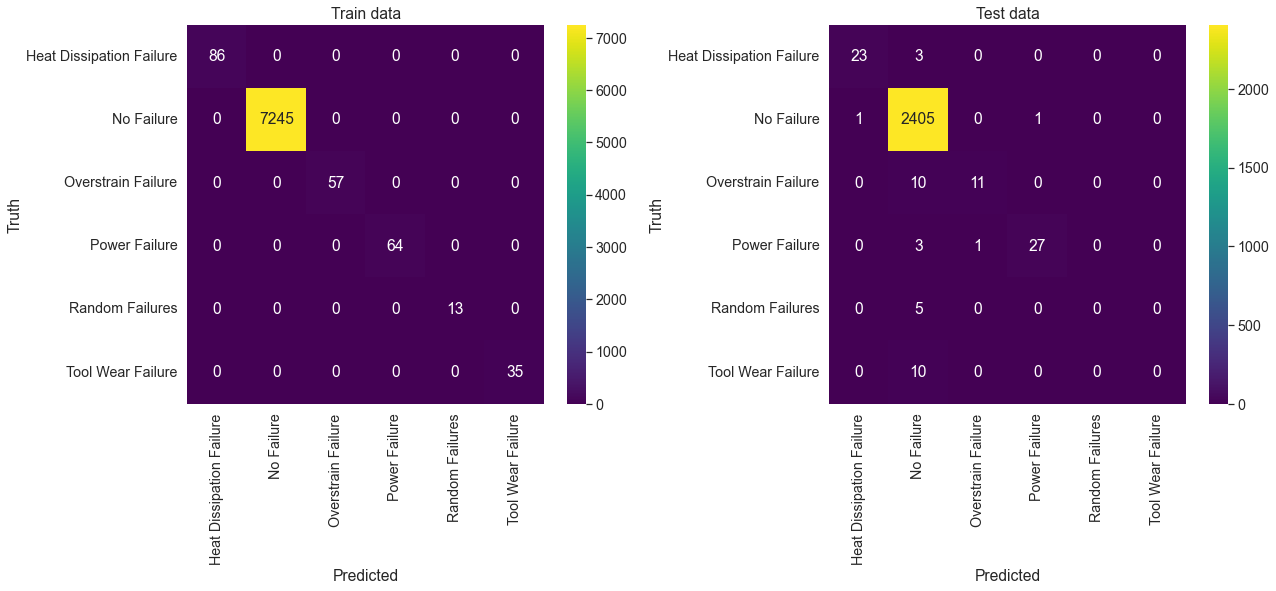

In [44]:
#Create the model
#use DecisionTreeClassifier() as base estimator in BaggingClassifier and fit
clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=100).fit(X_train,y_train)
#Predict train and test
y_tilde = clf.predict(X_train)
y_pred =clf.predict(X_test)
#Confusion matrix
cm_train = confusion_matrix(y_train, y_tilde)
cm_test = confusion_matrix(y_test, y_pred)
indexes = np.append(clf.classes_,['Macro averaged','Micro averaged'])
metrics = ['Accuracy','Precision','Recall','F1-score','Support(n samples)']
#Display the scores
print("Train data")
display(scores(y_train,y_tilde,indexes,metrics))
print("\nTest data")
display(scores(y_test,y_pred,indexes,metrics))
#Plotting the confusion matrices
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
fig.tight_layout()
fig.tight_layout(pad=10.0)
ax1 = plot_confusion_matrix(conf_mat = cm_train,ax=ax1,title = 'Train data',labels=clf.classes_)
ax2 = plot_confusion_matrix(conf_mat = cm_test,ax=ax2,title = 'Test data',labels=clf.classes_)

The model does indeed achieve a better scores than a simple decision tree. Note that "No Failure" class is a positive as well, so it likely has a near perfect accuracy on that class. From the confusion matrix above, we see that it's quite high for No failure, however somewhat low for the otthers, and even zero for Random failurs and tool wear failures.
 
Note that each tree has no restrictions and has likely grown to near the same depth as the first tree.

In [45]:
[est.get_depth() for est in clf.estimators_]

[15,
 15,
 17,
 18,
 17,
 17,
 19,
 19,
 19,
 19,
 20,
 14,
 14,
 16,
 18,
 17,
 19,
 18,
 17,
 18,
 16,
 16,
 17,
 17,
 17,
 18,
 16,
 19,
 18,
 16,
 18,
 17,
 18,
 17,
 17,
 17,
 17,
 18,
 17,
 16,
 19,
 16,
 17,
 21,
 17,
 17,
 18,
 18,
 18,
 19,
 17,
 16,
 16,
 20,
 15,
 18,
 19,
 16,
 15,
 16,
 18,
 16,
 17,
 20,
 15,
 17,
 17,
 15,
 17,
 16,
 16,
 18,
 19,
 17,
 20,
 19,
 15,
 20,
 18,
 18,
 16,
 20,
 17,
 22,
 19,
 20,
 17,
 20,
 16,
 18,
 15,
 17,
 20,
 18,
 16,
 15,
 16,
 19,
 18,
 19]

Most trees have 16 to 20 in depth, and so it shows that bootstrapping slightly changes the trees. One even has 13 in depth.

In [46]:
#Root node of the trees
nodes = 5 #Number of nodes to display
#Display dataframe of features at the different nodes of each tree
display(pd.DataFrame(np.asarray([[X.columns[est.tree_.feature[i]] for i in range(nodes)] for est in clf.estimators_]),
                     columns=['node {0}'.format(i) for i in range(nodes)]))


,node 0,node 1,node 2,node 3,node 4
0,Torque [Nm],Torque [Nm],Tool wear [min],Air temperature [K],L
1,Torque [Nm],Torque [Nm],L,Rotational speed [rpm],Air temperature [K]
2,Torque [Nm],Rotational speed [rpm],Rotational speed [rpm],Air temperature [K],Tool wear [min]
3,Torque [Nm],Torque [Nm],Tool wear [min],Rotational speed [rpm],L
4,Torque [Nm],Torque [Nm],Air temperature [K],Tool wear [min],Rotational speed [rpm]
...,...,...,...,...,...
95,Torque [Nm],Tool wear [min],Air temperature [K],L,Tool wear [min]
96,Torque [Nm],Torque [Nm],Air temperature [K],Tool wear [min],L
97,Torque [Nm],Torque [Nm],Air temperature [K],L,L
98,Torque [Nm],Torque [Nm],L,Rotational speed [rpm],Air temperature [K]


All trees uses Torque as the root node, which indeed makes sense due to its dominance in the single tree as well. Most seem to favor Torque in the second node as well, indicating that the torque is likely a much bigger predictor than the others.\
The second node seem to vary a bit more, showing that the bootstrapping does change the trees somewhat.

There are some parameters of a BaggingClassifier that should be tested. For the BaggingClassifier itself its mostly number of estimators, however for the decision tree used one can change both max_depth and pruning parameter.

{'base_estimator__max_depth': 25, 'n_estimators': 201}


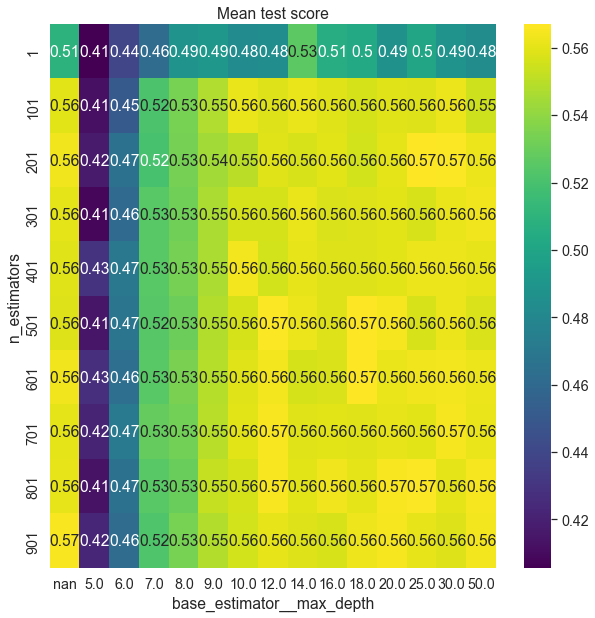

In [50]:
clf = BaggingClassifier(DecisionTreeClassifier())

estimators = range(1,1000,100)
depths = [5,6,7,8,9,10,12,14,16,18,20,25,30,50,None]
params = {'n_estimators':estimators,
          'base_estimator__max_depth':depths}

gs, res = grid_search_df(X_train,y_train,clf,params,'f1_macro')
print(gs.best_params_)
plot_grid_search(res,('n_estimators','base_estimator__max_depth'))

I seems about 200 estimators gave the best result however only slightly. Score does not seem to decrease with increasing number of estimators. Note also the 'nan' indicating no max depth. It may indicate the the more the merrier for a bagging model. In other words, increasing bagging classifiers simply increases the score up until a certain maximum. A small bit of pruning did seem to slightly improve the score at 900.

ValueError: Shape of passed values is (9, 2), indices imply (15, 2)

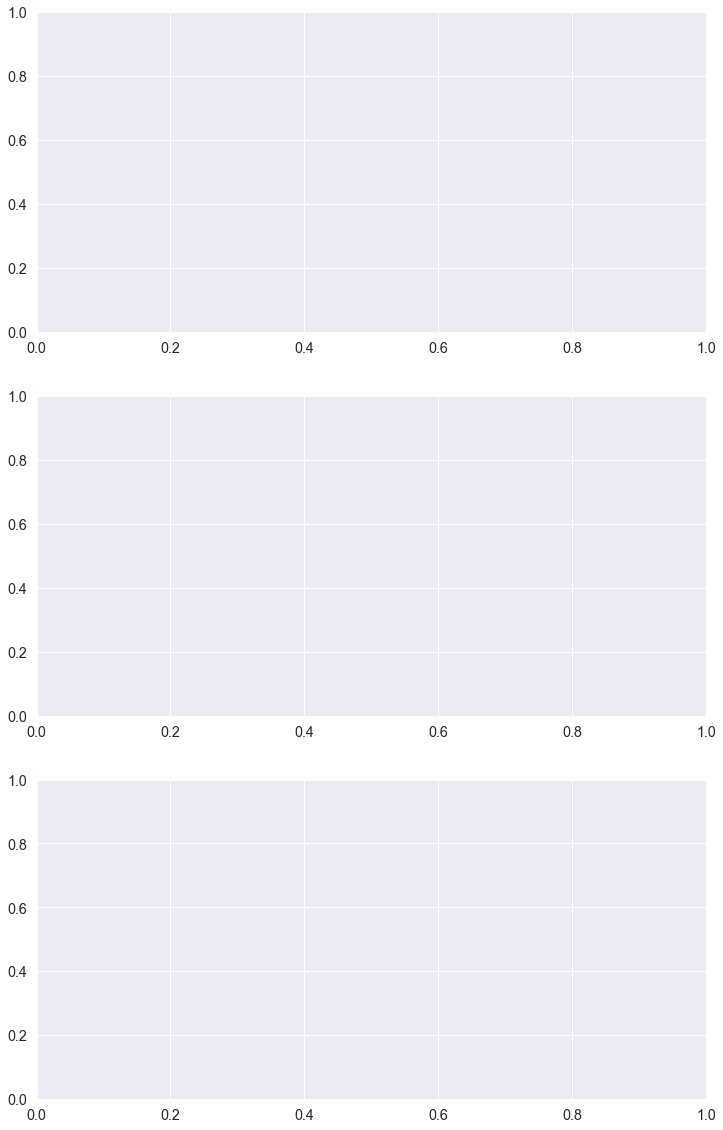

In [51]:
clf = BaggingClassifier(DecisionTreeClassifier())
estimators = np.asarray([10, 50, 100, 250, 300, 350, 400, 600, 1000],dtype=int)
params = {'n_estimators':estimators}
score_dict = evaluate_parameter(clf, params, ['f1','recall','precision'], X, y_m)


<AxesSubplot:title={'center':'Macro averaged Precision for Train and Test'}, xlabel='max_depth', ylabel='Precision'>

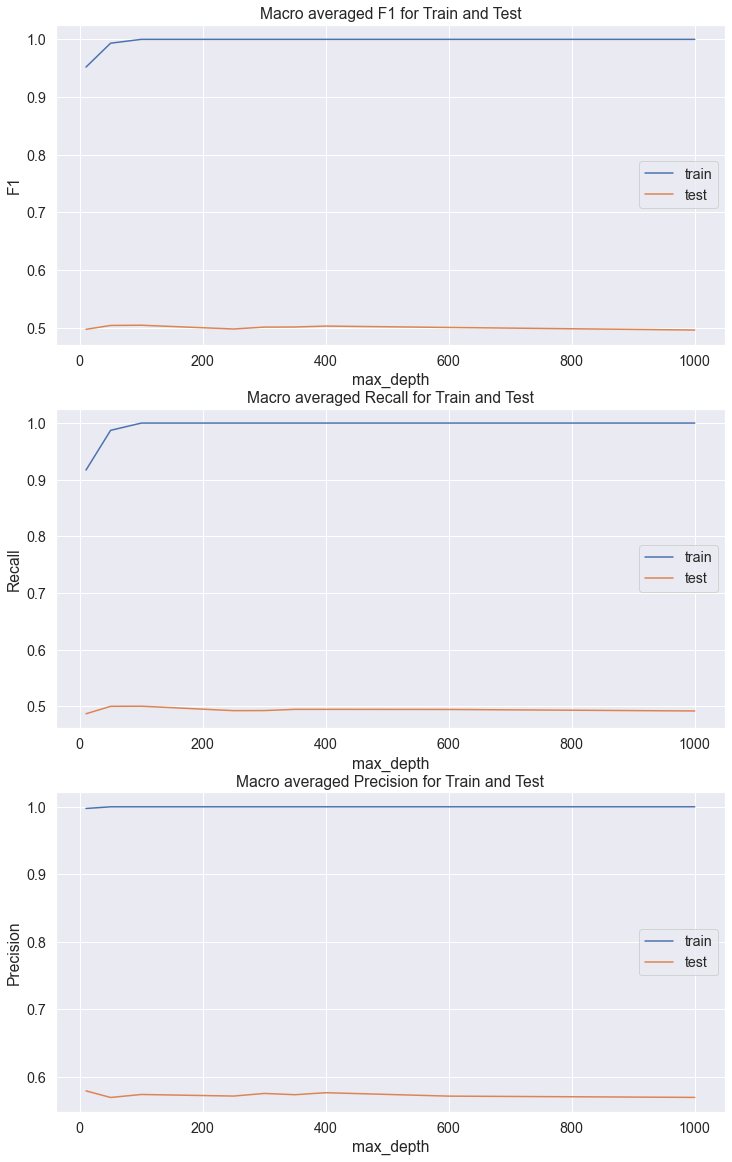

In [53]:
#Plotting
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (12,20))
pd.DataFrame(score_dict['f1'],index = estimators).plot(xlabel='max_depth',
                                                   ylabel='F1',
                                                   title='Macro averaged F1 for Train and Test',
                                                   ax=ax1)
pd.DataFrame(score_dict['recall'],index = estimators).plot(xlabel='max_depth',
                                                       ylabel='Recall',
                                                       title='Macro averaged Recall for Train and Test',
                                                       ax=ax2)
pd.DataFrame(score_dict['precision'],index = estimators).plot(xlabel='max_depth',
                                                          ylabel='Precision',
                                                          title='Macro averaged Precision for Train and Test',
                                                          ax=ax3)

In the interest of efficient computing, n_estimators of 200 is chosen as it seems it will yield similar score.

Train data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,1.0,1.0,1.0,1.0,86.0
No Failure,1.0,1.0,1.0,1.0,7245.0
Overstrain Failure,1.0,1.0,1.0,1.0,57.0
Power Failure,1.0,1.0,1.0,1.0,64.0
Random Failures,1.0,1.0,1.0,1.0,13.0
Tool Wear Failure,1.0,1.0,1.0,1.0,35.0
Macro averaged,1.0,1.0,1.0,1.0,None
Micro averaged,1.0,1.0,1.0,1.0,None



Test data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,0.884615,0.920000,0.884615,0.901961,26.0
No Failure,0.998754,0.988487,0.998754,0.993594,2407.0
Overstrain Failure,0.619048,0.928571,0.619048,0.742857,21.0
Power Failure,0.903226,0.965517,0.903226,0.933333,31.0
Random Failures,0.000000,0.000000,0.000000,0.000000,5.0
Tool Wear Failure,0.000000,0.000000,0.000000,0.000000,10.0
Macro averaged,0.567607,0.633763,0.567607,0.595291,None
Micro averaged,0.987200,0.987200,0.987200,0.987200,None


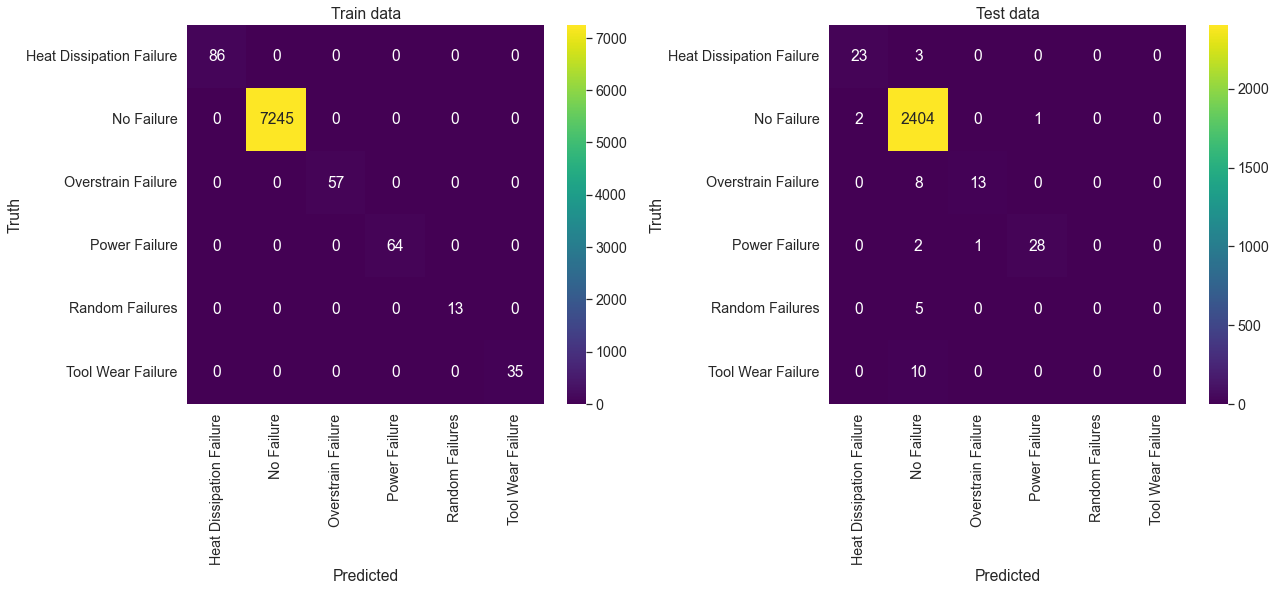

In [54]:
#Create the model
tree_clf = DecisionTreeClassifier()
#use tree_clf in BaggingClassifier and fit
clf = BaggingClassifier(tree_clf,n_estimators=200).fit(X_train,y_train)
#Predict train and test
y_tilde = clf.predict(X_train)
y_pred =clf.predict(X_test)
#Confusion matrix
cm_train = confusion_matrix(y_train, y_tilde)
cm_test = confusion_matrix(y_test, y_pred)
indexes = np.append(clf.classes_,['Macro averaged','Micro averaged'])
metrics = ['Accuracy','Precision','Recall','F1-score','Support(n samples)']
#Display the scores
print("Train data")
display(scores(y_train,y_tilde,indexes,metrics))
print("\nTest data")
display(scores(y_test,y_pred,indexes,metrics))
#Plotting the confusion matrices
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
fig.tight_layout()
fig.tight_layout(pad=10.0)
ax1 = plot_confusion_matrix(conf_mat = cm_train,ax=ax1,title = 'Train data',labels=clf.classes_)
ax2 = plot_confusion_matrix(conf_mat = cm_test,ax=ax2,title = 'Test data',labels=clf.classes_)

The scores for this model was slightly better than the inital BaggingClassifier. What is clear is that the models struggle with classifying random failures and tool wear failures, most likely because those classes are most sparse in the data set. This model is on the other hand, considerably better at the other classes especially on power failure and heat disipation failure. This may show that such a model might be useful to detect these clases specifically.

In [147]:
indexes = ['HDF','NF','OF','PF','RF','TWF','Macro avg','Micro avg']
df = scores(y_test,y_pred,indexes,metrics).astype(float).round(2)
df.index = indexes

print(df.to_latex(columns=['Accuracy','Precision','Recall','F1-score']))

\begin{tabular}{lrrrr}
\toprule
{} &  Accuracy &  Precision &  Recall &  F1-score \\
\midrule
HDF       &      0.88 &       0.85 &    0.88 &      0.87 \\
NF        &      1.00 &       0.99 &    1.00 &      0.99 \\
OF        &      0.76 &       0.80 &    0.76 &      0.78 \\
PF        &      0.74 &       0.96 &    0.74 &      0.84 \\
RF        &      0.00 &       0.00 &    0.00 &      0.00 \\
TWF       &      0.00 &       0.00 &    0.00 &      0.00 \\
Macro avg &      0.56 &       0.60 &    0.56 &      0.58 \\
Micro avg &      0.98 &       0.98 &    0.98 &      0.98 \\
\bottomrule
\end{tabular}



#### Bias variance

<AxesSubplot:title={'center':'Variance'}>

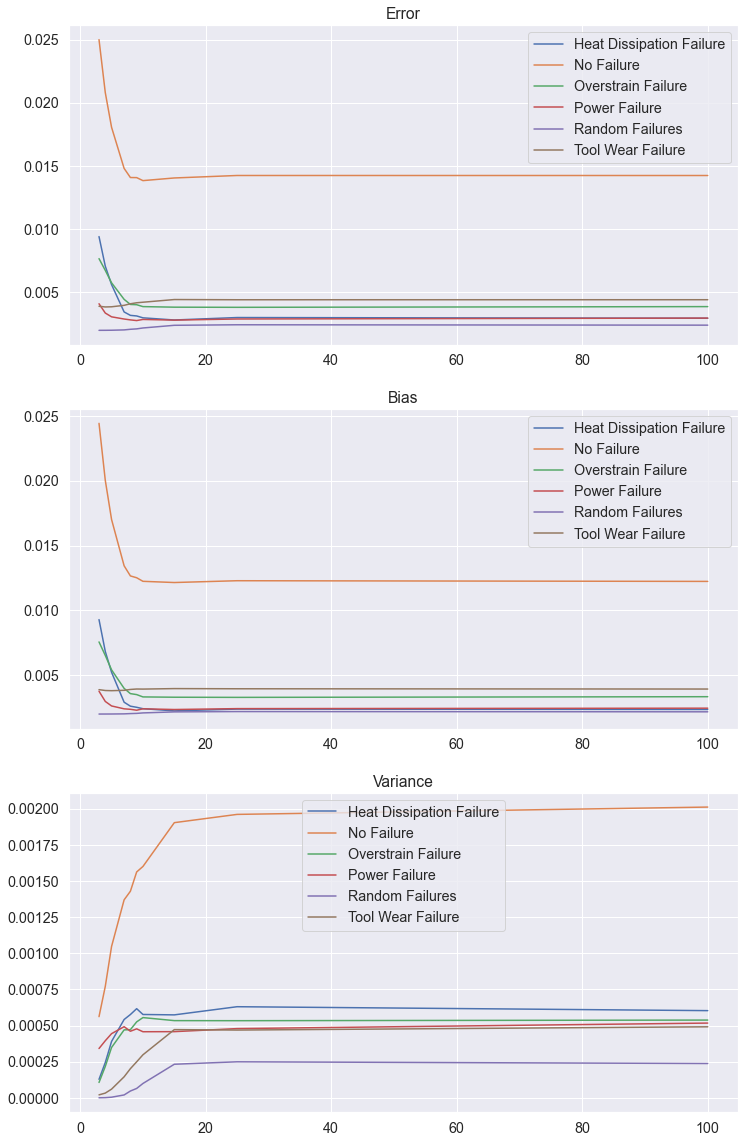

In [104]:
clf = BaggingClassifier(tree_clf,n_estimators=200)
#Tree depths to test
complexity = {'base_estimator__max_depth':[3,4,5,7,8,9,10,15,25,100]}
#Calculating bias variance on all complexity params
err,bi,var = bias_var_analysis(clf,X_train, X_test, y_train,y_test,complexity,100)
#Creating data frames
err_df = pd.DataFrame(err,columns=clf.classes_,index=list(complexity.values())[0])
bi_df = pd.DataFrame(bi,columns=clf.classes_,index=list(complexity.values())[0])
var_df = pd.DataFrame(var,columns=clf.classes_,index=list(complexity.values())[0])
#Plotting
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (12,20))
err_df.plot(title='Error',ax=ax1)
bi_df.plot(title='Bias',ax=ax2)
var_df.plot(title='Variance',ax=ax3)

<AxesSubplot:title={'center':'Bias Variance for complete model'}>

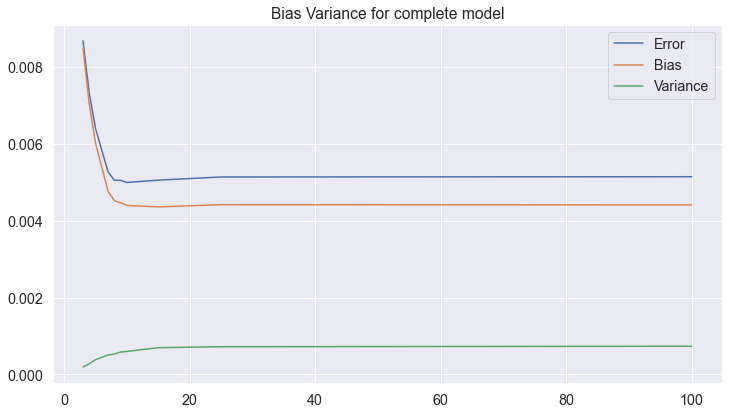

In [106]:
fig, ax1 = plt.subplots(1,1,figsize = (12,6.6))
pd.DataFrame(np.column_stack([np.mean(err,axis=1),np.mean(bi,axis=1),np.mean(var,axis=1)]),
             columns=['Error','Bias','Variance'],
             index=list(complexity.values())[0]).plot(title='Bias Variance for complete model',ax=ax1)

### Benchmarking

Train data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,1.0,1.0,1.0,1.0,86.0
No Failure,1.0,1.0,1.0,1.0,7245.0
Overstrain Failure,1.0,1.0,1.0,1.0,57.0
Power Failure,1.0,1.0,1.0,1.0,64.0
Random Failures,1.0,1.0,1.0,1.0,13.0
Tool Wear Failure,1.0,1.0,1.0,1.0,35.0
Macro averaged,1.0,1.0,1.0,1.0,None
Micro averaged,1.0,1.0,1.0,1.0,None



Test data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,0.884615,0.958333,0.884615,0.920000,26.0
No Failure,0.998754,0.988487,0.998754,0.993594,2407.0
Overstrain Failure,0.666667,0.875000,0.666667,0.756757,21.0
Power Failure,0.870968,0.964286,0.870968,0.915254,31.0
Random Failures,0.000000,0.000000,0.000000,0.000000,5.0
Tool Wear Failure,0.000000,0.000000,0.000000,0.000000,10.0
Macro averaged,0.570167,0.631018,0.570167,0.597601,None
Micro averaged,0.987200,0.987200,0.987200,0.987200,None


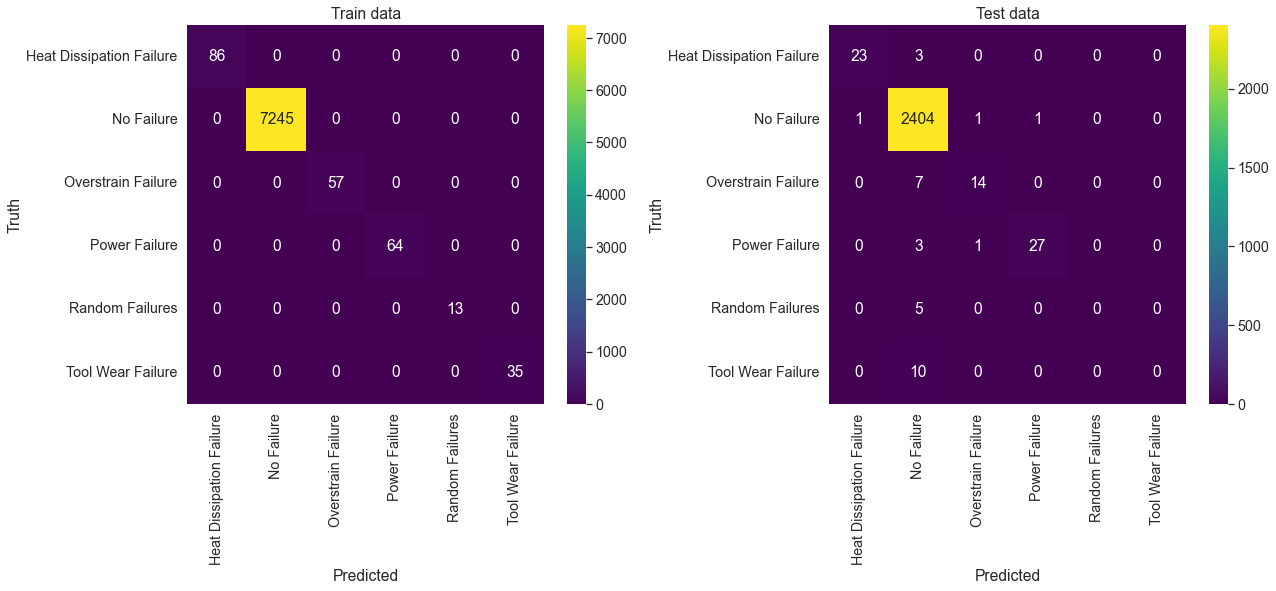

In [137]:
#Create the model
#use DecisionTreeClassifier() as base estimator in BaggingClassifier and fit
clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=200).fit(X_train,y_train)
#Predict train and test
y_tilde = clf.predict(X_train)
y_pred =clf.predict(X_test)
#Confusion matrix
cm_train = confusion_matrix(y_train, y_tilde)
cm_test = confusion_matrix(y_test, y_pred)
indexes = np.append(clf.classes_,['Macro averaged','Micro averaged'])
metrics = ['Accuracy','Precision','Recall','F1-score','Support(n samples)']
#Display the scores
print("Train data")
display(scores(y_train,y_tilde,indexes,metrics))
print("\nTest data")
display(scores(y_test,y_pred,indexes,metrics))
#Plotting the confusion matrices
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
fig.tight_layout()
fig.tight_layout(pad=10.0)
ax1 = plot_confusion_matrix(conf_mat = cm_train,ax=ax1,title = 'Train data',labels=clf.classes_)
ax2 = plot_confusion_matrix(conf_mat = cm_test,ax=ax2,title = 'Test data',labels=clf.classes_)

In [58]:
#Must use a stratified kfold due to class imbalance
cvs = StratifiedKFold(shuffle=True,n_splits=4)
clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=200)
#Cross validating f1 score
dt1_f1 = np.mean(cross_val_score(clf,X,y_m,scoring='f1_macro',n_jobs=-1,cv=cvs))
dt1_recall = np.mean(cross_val_score(clf,X,y_m,scoring='recall_macro',n_jobs=-1,cv=cvs))
dt1_precision = np.mean(cross_val_score(clf,X,y_m,scoring='precision_macro',n_jobs=-1,cv=cvs))
print('Cross validated F1 score: \t\t',dt1_f1)
print('Cross validated recall score: \t\t',dt1_recall)
print('Cross validated precision score: \t',dt1_precision)

Cross validated F1 score: 		 0.561301666276243
Cross validated recall score: 		 0.5380556915868926
Cross validated precision score: 	 0.6047661244040495


## Random Forests

Train data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,1.0,1.0,1.0,1.0,86.0
No Failure,1.0,1.0,1.0,1.0,7245.0
Overstrain Failure,1.0,1.0,1.0,1.0,57.0
Power Failure,1.0,1.0,1.0,1.0,64.0
Random Failures,1.0,1.0,1.0,1.0,13.0
Tool Wear Failure,1.0,1.0,1.0,1.0,35.0
Macro averaged,1.0,1.0,1.0,1.0,None
Micro averaged,1.0,1.0,1.0,1.0,None



Test data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,0.769231,1.00000,0.769231,0.869565,26.0
No Failure,0.999169,0.98364,0.999169,0.991344,2407.0
Overstrain Failure,0.428571,0.90000,0.428571,0.580645,21.0
Power Failure,0.741935,0.92000,0.741935,0.821429,31.0
Random Failures,0.000000,0.00000,0.000000,0.000000,5.0
Tool Wear Failure,0.000000,0.00000,0.000000,0.000000,10.0
Macro averaged,0.489818,0.63394,0.489818,0.543830,None
Micro averaged,0.982800,0.98280,0.982800,0.982800,None


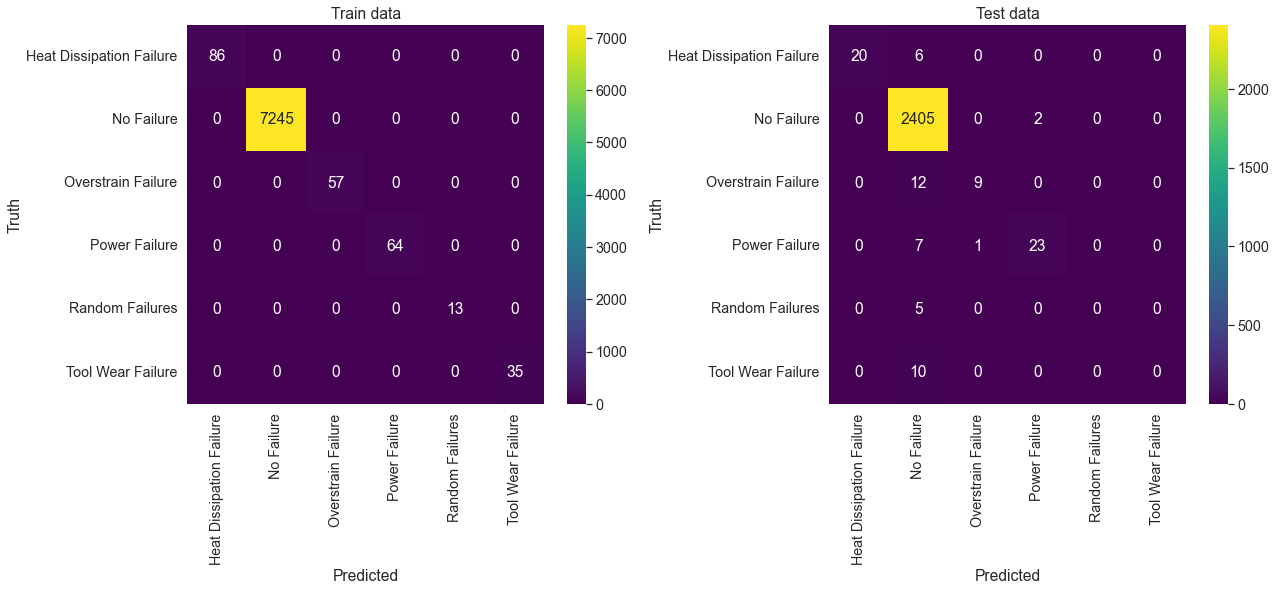

In [59]:
#Create the model
clf = RandomForestClassifier(max_features=3).fit(X_train,y_train)
#Predict train and test
y_tilde = clf.predict(X_train)
y_pred =clf.predict(X_test)
#Confusion matrix
cm_train = confusion_matrix(y_train, y_tilde)
cm_test = confusion_matrix(y_test, y_pred)
indexes = np.append(clf.classes_,['Macro averaged','Micro averaged'])
metrics = ['Accuracy','Precision','Recall','F1-score','Support(n samples)']
#Display the scores
print("Train data")
display(scores(y_train,y_tilde,indexes,metrics))
print("\nTest data")
display(scores(y_test,y_pred,indexes,metrics))
#Plotting the confusion matrices
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
fig.tight_layout()
fig.tight_layout(pad=10.0)
ax1 = plot_confusion_matrix(conf_mat = cm_train,ax=ax1,title = 'Train data',labels=clf.classes_)
ax2 = plot_confusion_matrix(conf_mat = cm_test,ax=ax2,title = 'Test data',labels=clf.classes_)

The random forest does obtain a perfect score on the train set, however not the best result on the test data. Again random failures and tool wear seems hard to predict.

In [60]:
[est.get_depth() for est in clf.estimators_]

[18,
 16,
 19,
 17,
 16,
 19,
 16,
 16,
 18,
 17,
 17,
 17,
 16,
 18,
 13,
 18,
 17,
 15,
 18,
 17,
 18,
 15,
 18,
 23,
 20,
 20,
 15,
 16,
 18,
 17,
 19,
 16,
 16,
 17,
 18,
 18,
 17,
 16,
 20,
 19,
 16,
 16,
 19,
 15,
 14,
 17,
 18,
 18,
 18,
 15,
 20,
 18,
 18,
 16,
 20,
 20,
 18,
 22,
 16,
 17,
 20,
 16,
 18,
 20,
 18,
 15,
 15,
 18,
 16,
 18,
 21,
 20,
 16,
 17,
 17,
 15,
 16,
 14,
 19,
 16,
 15,
 20,
 19,
 16,
 17,
 18,
 15,
 19,
 19,
 18,
 18,
 15,
 20,
 18,
 18,
 18,
 15,
 17,
 18,
 15]

With a 100 estimators, the list is rather long. Though note that most of them still reaches a depth of around 20. Some here also exceeds 20 indicating that a deeper tree is required when some features are left out.

In [61]:
#Root node of the trees
nodes = 5 #Number of nodes to display
#Display dataframe of features at the different nodes of each tree
display(pd.DataFrame(np.asarray([[X.columns[est.tree_.feature[i]] for i in range(nodes)] for est in clf.estimators_]),
                     columns=['node {0}'.format(i) for i in range(nodes)]))

,node 0,node 1,node 2,node 3,node 4
0,Rotational speed [rpm],Air temperature [K],Tool wear [min],Torque [Nm],Torque [Nm]
1,Tool wear [min],Air temperature [K],Torque [Nm],L,Torque [Nm]
2,Rotational speed [rpm],Air temperature [K],Rotational speed [rpm],Process temperature [K],Tool wear [min]
3,Rotational speed [rpm],Air temperature [K],Rotational speed [rpm],Torque [Nm],L
4,Process temperature [K],Torque [Nm],M,Torque [Nm],L
...,...,...,...,...,...
95,Torque [Nm],Tool wear [min],Process temperature [K],Rotational speed [rpm],Tool wear [min]
96,Tool wear [min],Torque [Nm],Torque [Nm],Air temperature [K],L
97,Torque [Nm],Torque [Nm],L,Torque [Nm],Rotational speed [rpm]
98,Tool wear [min],Torque [Nm],Rotational speed [rpm],Rotational speed [rpm],Process temperature [K]


Table shows the randomness of chosen features.

{'max_features': 4, 'n_estimators': 201}


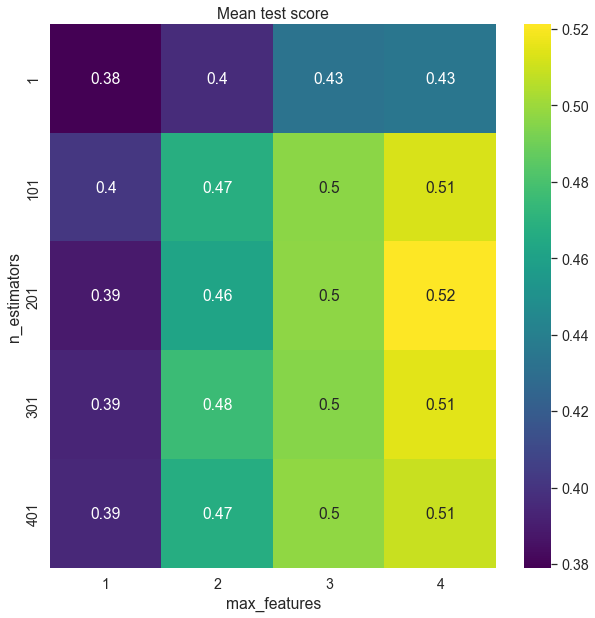

In [65]:
clf = RandomForestClassifier()
estimators = range(1,500,100)
max_features = [1,2,3,4]

params = {'n_estimators':estimators,
          'max_features':max_features}

gs, res = grid_search_df(X_train,y_train,clf,params,'f1_macro')
print(gs.best_params_)
plot_grid_search(res,('n_estimators','max_features'))

It seems a max depth of 21 with about 700 estimators seem to achieve a good score, though the score seems to saturate rather quickly. Already at max depth 13 and 100 estimators a 0.49 f1 score is achieved.

#### Bias variance

<AxesSubplot:title={'center':'Variance'}>

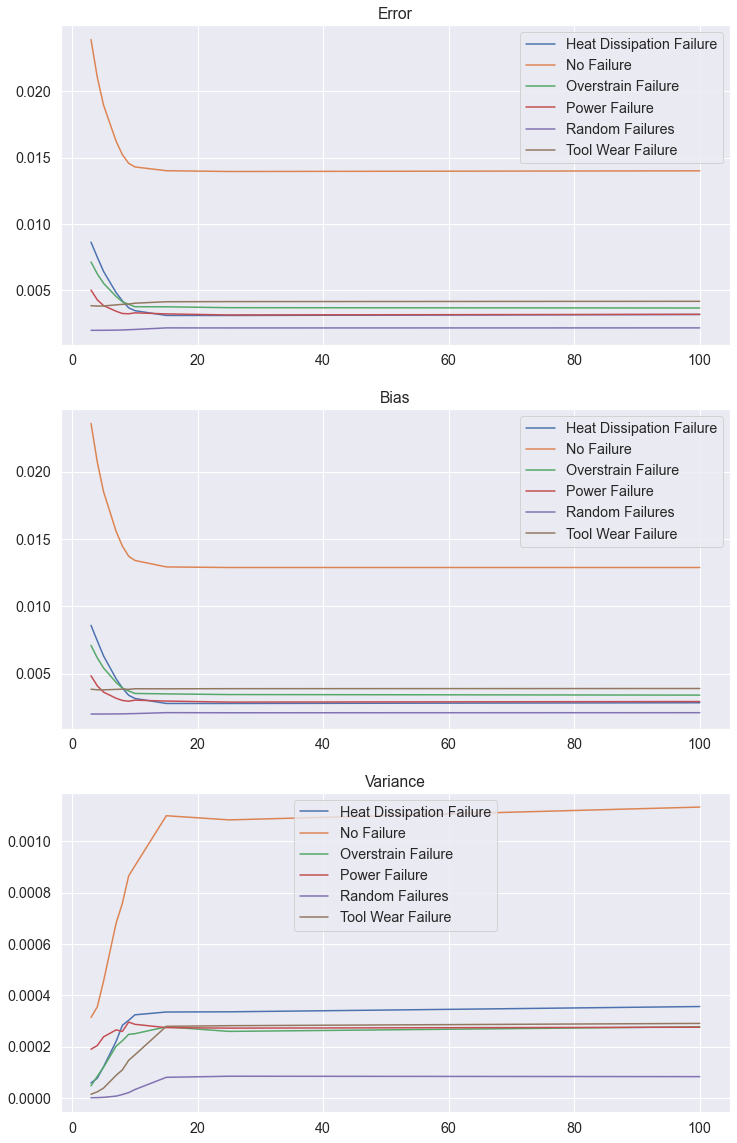

In [107]:
clf = RandomForestClassifier(max_features=4,n_estimators = 200)
#Tree depths to test
complexity = {'max_depth':[3,4,5,7,8,9,10,15,25,100]}
#Calculating bias variance on all complexity params
err,bi,var = bias_var_analysis(clf,X_train, X_test, y_train,y_test,complexity,100)
#Creating data frames
err_df = pd.DataFrame(err,columns=clf.classes_,index=list(complexity.values())[0])
bi_df = pd.DataFrame(bi,columns=clf.classes_,index=list(complexity.values())[0])
var_df = pd.DataFrame(var,columns=clf.classes_,index=list(complexity.values())[0])
#Plotting
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (12,20))
err_df.plot(title='Error',ax=ax1)
bi_df.plot(title='Bias',ax=ax2)
var_df.plot(title='Variance',ax=ax3)

<AxesSubplot:title={'center':'Bias Variance for complete model'}>

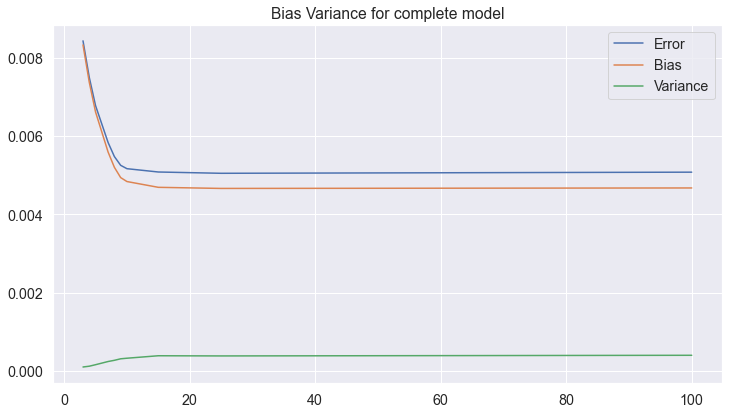

In [108]:
fig, ax1 = plt.subplots(1,1,figsize = (12,6.6))
pd.DataFrame(np.column_stack([np.mean(err,axis=1),np.mean(bi,axis=1),np.mean(var,axis=1)]),
             columns=['Error','Bias','Variance'],
             index=list(complexity.values())[0]).plot(title='Bias Variance for complete model',ax=ax1)

### Benchmarking

Train data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,1.0,1.0,1.0,1.0,86.0
No Failure,1.0,1.0,1.0,1.0,7245.0
Overstrain Failure,1.0,1.0,1.0,1.0,57.0
Power Failure,1.0,1.0,1.0,1.0,64.0
Random Failures,1.0,1.0,1.0,1.0,13.0
Tool Wear Failure,1.0,1.0,1.0,1.0,35.0
Macro averaged,1.0,1.0,1.0,1.0,None
Micro averaged,1.0,1.0,1.0,1.0,None



Test data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,0.846154,1.000000,0.846154,0.916667,26.0
No Failure,0.999169,0.984848,0.999169,0.991957,2407.0
Overstrain Failure,0.428571,0.900000,0.428571,0.580645,21.0
Power Failure,0.774194,0.960000,0.774194,0.857143,31.0
Random Failures,0.000000,0.000000,0.000000,0.000000,5.0
Tool Wear Failure,0.000000,0.000000,0.000000,0.000000,10.0
Macro averaged,0.508015,0.640808,0.508015,0.557735,None
Micro averaged,0.984000,0.984000,0.984000,0.984000,None


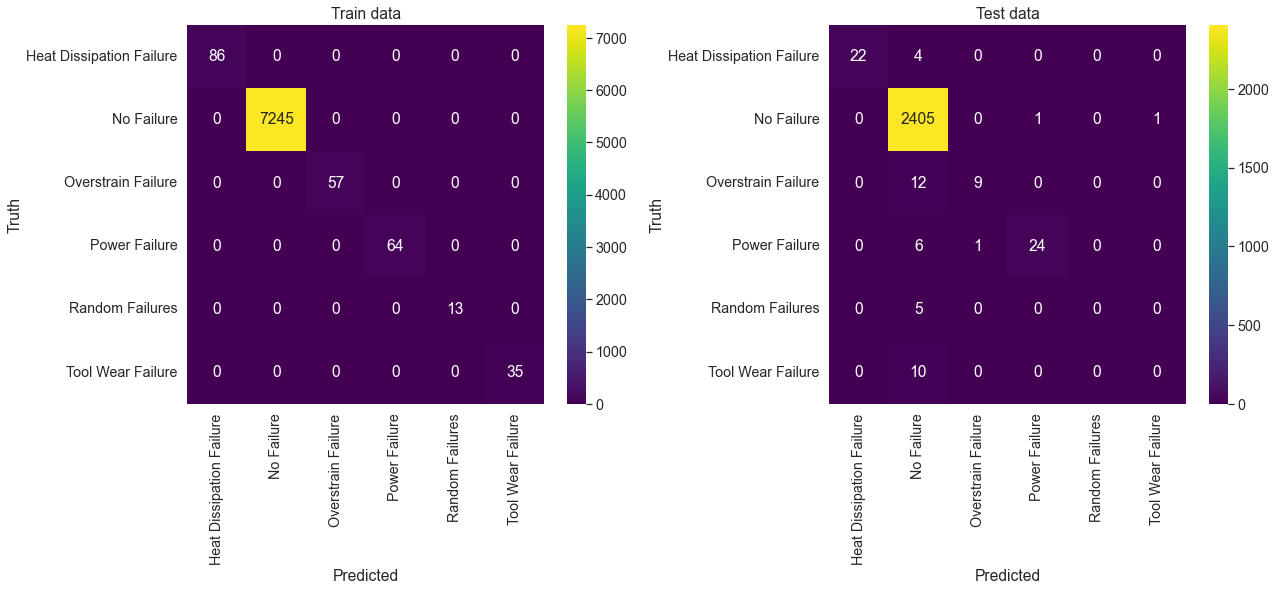

In [139]:

#Create the model
#use DecisionTreeClassifier() as base estimator in BaggingClassifier and fit
clf = RandomForestClassifier(max_features=4,n_estimators = 200).fit(X_train,y_train)
#Predict train and test
y_tilde = clf.predict(X_train)
y_pred =clf.predict(X_test)
#Confusion matrix
cm_train = confusion_matrix(y_train, y_tilde)
cm_test = confusion_matrix(y_test, y_pred)
indexes = np.append(clf.classes_,['Macro averaged','Micro averaged'])
metrics = ['Accuracy','Precision','Recall','F1-score','Support(n samples)']
#Display the scores
print("Train data")
display(scores(y_train,y_tilde,indexes,metrics))
print("\nTest data")
display(scores(y_test,y_pred,indexes,metrics))
#Plotting the confusion matrices
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
fig.tight_layout()
fig.tight_layout(pad=10.0)
ax1 = plot_confusion_matrix(conf_mat = cm_train,ax=ax1,title = 'Train data',labels=clf.classes_)
ax2 = plot_confusion_matrix(conf_mat = cm_test,ax=ax2,title = 'Test data',labels=clf.classes_)

In [110]:
#Must use a stratified kfold due to class imbalance
cvs = StratifiedKFold(shuffle=True,n_splits=4)
clf = RandomForestClassifier(max_features=4,n_estimators = 200)
#Cross validating f1 score
dt1_f1 = np.mean(cross_val_score(clf,X,y_m,scoring='f1_macro',n_jobs=-1,cv=cvs))
dt1_recall = np.mean(cross_val_score(clf,X,y_m,scoring='recall_macro',n_jobs=-1,cv=cvs))
dt1_precision = np.mean(cross_val_score(clf,X,y_m,scoring='precision_macro',n_jobs=-1,cv=cvs))
print('Cross validated F1 score: \t\t',dt1_f1)
print('Cross validated recall score: \t\t',dt1_recall)
print('Cross validated precision score: \t',dt1_precision)

Cross validated F1 score: 		 0.5420077048712
Cross validated recall score: 		 0.512277251813775
Cross validated precision score: 	 0.5902421006334245


# AdaBoost

Train data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,1.0,1.0,1.0,1.0,86.0
No Failure,1.0,1.0,1.0,1.0,7245.0
Overstrain Failure,1.0,1.0,1.0,1.0,57.0
Power Failure,1.0,1.0,1.0,1.0,64.0
Random Failures,1.0,1.0,1.0,1.0,13.0
Tool Wear Failure,1.0,1.0,1.0,1.0,35.0
Macro averaged,1.0,1.0,1.0,1.0,None
Micro averaged,1.0,1.0,1.0,1.0,None



Test data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,0.807692,0.777778,0.807692,0.792453,26.0
No Failure,0.989614,0.987972,0.989614,0.988792,2407.0
Overstrain Failure,0.571429,0.631579,0.571429,0.600000,21.0
Power Failure,0.774194,0.923077,0.774194,0.842105,31.0
Random Failures,0.000000,0.000000,0.000000,0.000000,5.0
Tool Wear Failure,0.200000,0.142857,0.200000,0.166667,10.0
Macro averaged,0.557155,0.577210,0.557155,0.565003,None
Micro averaged,0.976400,0.976400,0.976400,0.976400,None


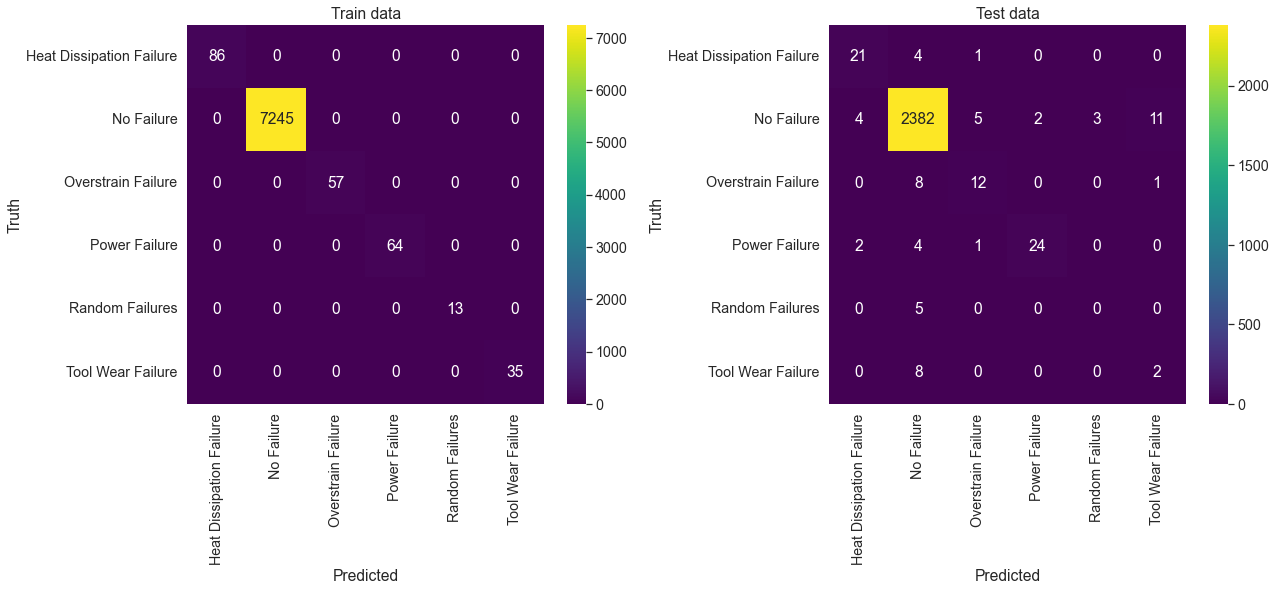

In [111]:
#Create the model
tree_clf = DecisionTreeClassifier()
#use tree_clf in BaggingClassifier and fit
clf = AdaBoostClassifier(DecisionTreeClassifier()).fit(X_train,y_train)
#Predict train and test
y_tilde = clf.predict(X_train)
y_pred =clf.predict(X_test)
#Confusion matrix
cm_train = confusion_matrix(y_train, y_tilde)
cm_test = confusion_matrix(y_test, y_pred)
indexes = np.append(clf.classes_,['Macro averaged','Micro averaged'])
metrics = ['Accuracy','Precision','Recall','F1-score','Support(n samples)']
#Display the scores
print("Train data")
display(scores(y_train,y_tilde,indexes,metrics))
print("\nTest data")
display(scores(y_test,y_pred,indexes,metrics))
#Plotting the confusion matrices
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
fig.tight_layout()
fig.tight_layout(pad=10.0)
ax1 = plot_confusion_matrix(conf_mat = cm_train,ax=ax1,title = 'Train data',labels=clf.classes_)
ax2 = plot_confusion_matrix(conf_mat = cm_test,ax=ax2,title = 'Test data',labels=clf.classes_)

The default parameters to the adaboost algorithm does score quite horribly. It still gets a lot of the non-failure cases correct, but overall it performs very bad. It may be due to the fact that base estimators with max depth 1 is simply not much better than guessing at random, except for No Failure and Power Failure.

In [69]:
#Root node of the trees
nodes = 1 #Number of nodes to display
#Display dataframe of features at the different nodes of each tree
display(pd.DataFrame(np.asarray([[X.columns[est.tree_.feature[i]] for i in range(nodes)] for est in clf.estimators_]),
                     columns=['node {0}'.format(i) for i in range(nodes)]))

,node 0
0,Torque [Nm]


There seem to be a lot of focus on the torque, though also tool wear and rotational speed, which hasn't been the case earlier.

{'base_estimator__max_depth': 8, 'n_estimators': 50}


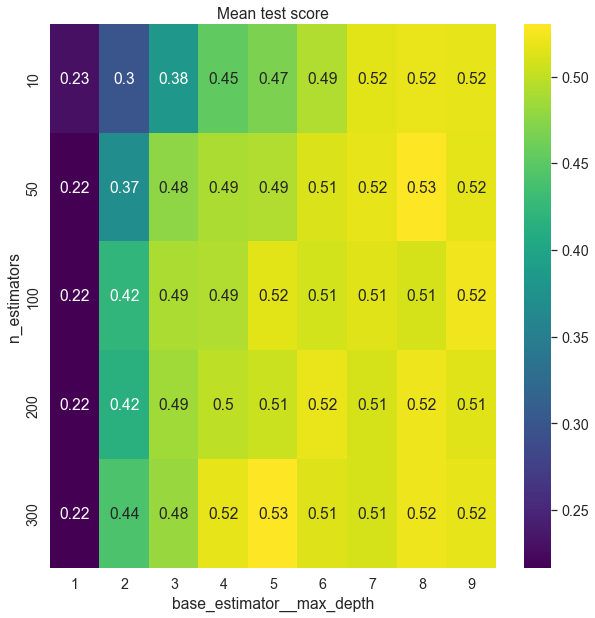

In [71]:
clf = AdaBoostClassifier(DecisionTreeClassifier())
estimators = [10,50,100,200,300]
depths = np.arange(1,10)
params = {'n_estimators':estimators,
          'base_estimator__max_depth':depths}

gs, res = grid_search_df(X_train,y_train,clf,params,'f1_macro')
print(gs.best_params_)
plot_grid_search(res,('n_estimators','base_estimator__max_depth'))

#### Bias variance

<AxesSubplot:title={'center':'Variance'}>

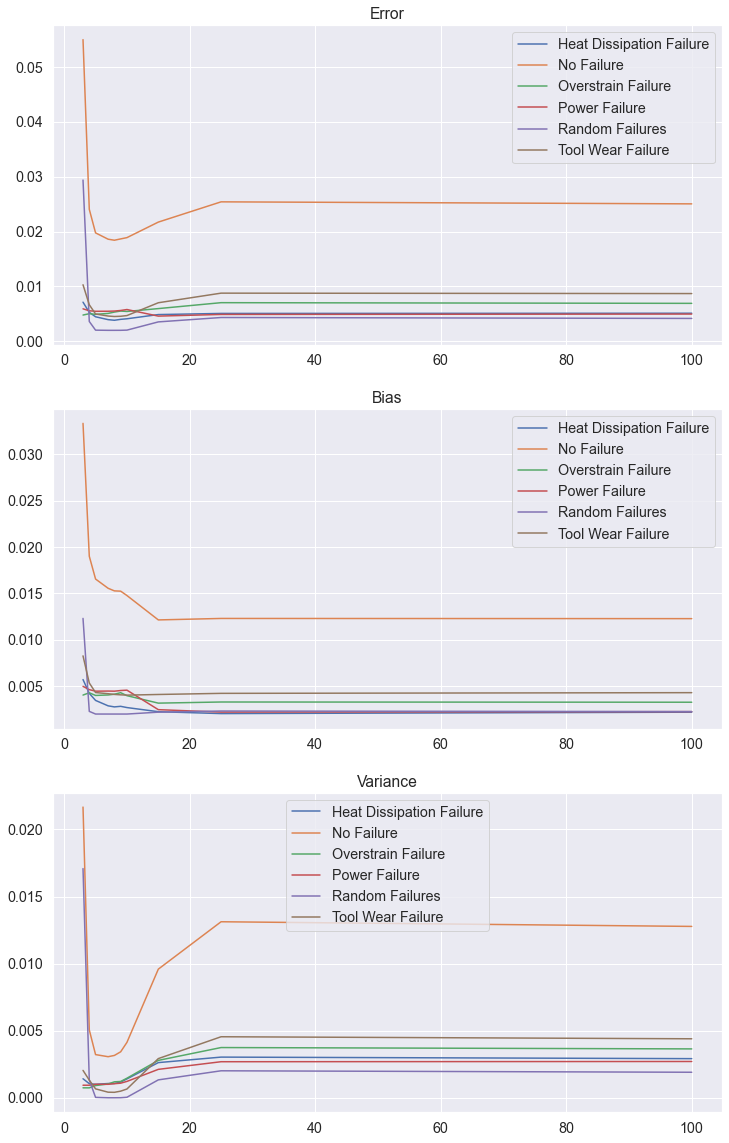

In [113]:
clf = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=50)
#Tree depths to test
complexity = {'base_estimator__max_depth':[3,4,5,7,8,9,10,15,25,100]}
#Calculating bias variance on all complexity params
err,bi,var = bias_var_analysis(clf,X_train, X_test, y_train,y_test,complexity,100)
#Creating data frames
err_df = pd.DataFrame(err,columns=clf.classes_,index=list(complexity.values())[0])
bi_df = pd.DataFrame(bi,columns=clf.classes_,index=list(complexity.values())[0])
var_df = pd.DataFrame(var,columns=clf.classes_,index=list(complexity.values())[0])
#Plotting
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (12,20))
err_df.plot(title='Error',ax=ax1)
bi_df.plot(title='Bias',ax=ax2)
var_df.plot(title='Variance',ax=ax3)

<AxesSubplot:title={'center':'Bias Variance for complete model'}>

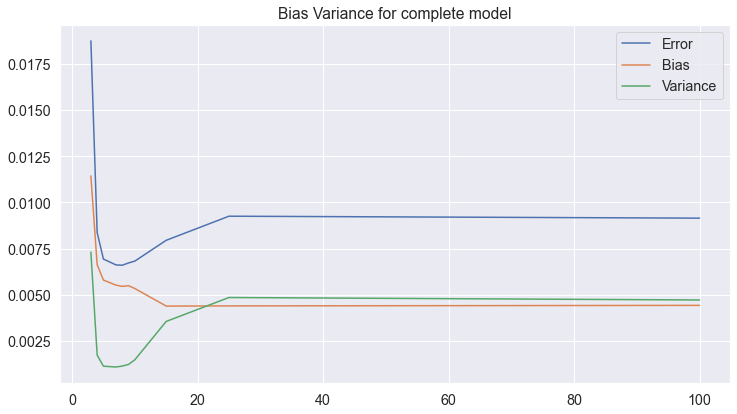

In [114]:
fig, ax1 = plt.subplots(1,1,figsize = (12,6.6))
pd.DataFrame(np.column_stack([np.mean(err,axis=1),np.mean(bi,axis=1),np.mean(var,axis=1)]),
             columns=['Error','Bias','Variance'],
             index=list(complexity.values())[0]).plot(title='Bias Variance for complete model',ax=ax1)

### Benchmarking

Train data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,1.0,1.0,1.0,1.0,86.0
No Failure,1.0,1.0,1.0,1.0,7245.0
Overstrain Failure,1.0,1.0,1.0,1.0,57.0
Power Failure,1.0,1.0,1.0,1.0,64.0
Random Failures,1.0,1.0,1.0,1.0,13.0
Tool Wear Failure,1.0,1.0,1.0,1.0,35.0
Macro averaged,1.0,1.0,1.0,1.0,None
Micro averaged,1.0,1.0,1.0,1.0,None



Test data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,0.692308,1.000000,0.692308,0.818182,26.0
No Failure,0.998338,0.982822,0.998338,0.990519,2407.0
Overstrain Failure,0.476190,0.769231,0.476190,0.588235,21.0
Power Failure,0.645161,0.952381,0.645161,0.769231,31.0
Random Failures,0.000000,0.000000,0.000000,0.000000,5.0
Tool Wear Failure,0.000000,0.000000,0.000000,0.000000,10.0
Macro averaged,0.468666,0.617406,0.468666,0.527695,None
Micro averaged,0.980400,0.980400,0.980400,0.980400,None


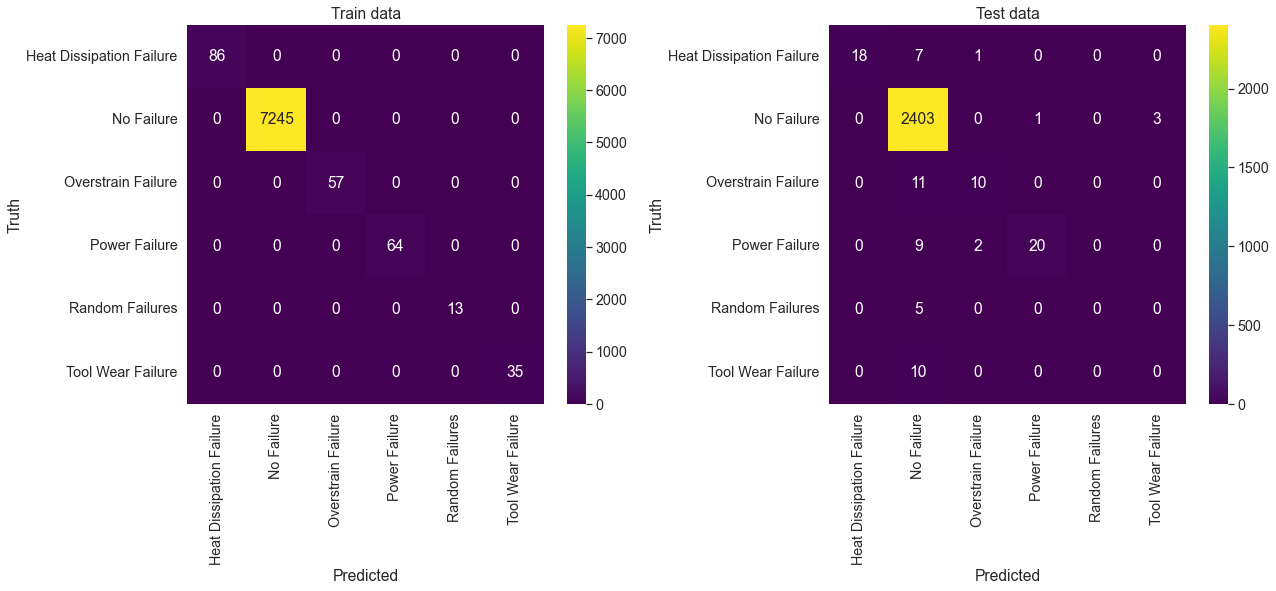

In [141]:
#Create the model
#use DecisionTreeClassifier() as base estimator in BaggingClassifier and fit
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8),n_estimators=50).fit(X_train,y_train)
#Predict train and test
y_tilde = clf.predict(X_train)
y_pred =clf.predict(X_test)
#Confusion matrix
cm_train = confusion_matrix(y_train, y_tilde)
cm_test = confusion_matrix(y_test, y_pred)
indexes = np.append(clf.classes_,['Macro averaged','Micro averaged'])
metrics = ['Accuracy','Precision','Recall','F1-score','Support(n samples)']
#Display the scores
print("Train data")
display(scores(y_train,y_tilde,indexes,metrics))
print("\nTest data")
display(scores(y_test,y_pred,indexes,metrics))
#Plotting the confusion matrices
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
fig.tight_layout()
fig.tight_layout(pad=10.0)
ax1 = plot_confusion_matrix(conf_mat = cm_train,ax=ax1,title = 'Train data',labels=clf.classes_)
ax2 = plot_confusion_matrix(conf_mat = cm_test,ax=ax2,title = 'Test data',labels=clf.classes_)

In [74]:

#Must use a stratified kfold due to class imbalance
cvs = StratifiedKFold(shuffle=True,n_splits=4)
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8),n_estimators=50)
#Cross validating f1 score
dt1_f1 = np.mean(cross_val_score(clf,X,y_m,scoring='f1_macro',n_jobs=-1,cv=cvs))
dt1_recall = np.mean(cross_val_score(clf,X,y_m,scoring='recall_macro',n_jobs=-1,cv=cvs))
dt1_precision = np.mean(cross_val_score(clf,X,y_m,scoring='precision_macro',n_jobs=-1,cv=cvs))
print('Cross validated F1 score: \t\t',dt1_f1)
print('Cross validated recall score: \t\t',dt1_recall)
print('Cross validated precision score: \t',dt1_precision)

Cross validated F1 score: 		 0.5563364352908166
Cross validated recall score: 		 0.5024980492641509
Cross validated precision score: 	 0.6617518094458288


# Gradient Boosting(sklearn)

Train data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,1.0,1.0,1.0,1.0,86.0
No Failure,1.0,1.0,1.0,1.0,7245.0
Overstrain Failure,1.0,1.0,1.0,1.0,57.0
Power Failure,1.0,1.0,1.0,1.0,64.0
Random Failures,1.0,1.0,1.0,1.0,13.0
Tool Wear Failure,1.0,1.0,1.0,1.0,35.0
Macro averaged,1.0,1.0,1.0,1.0,None
Micro averaged,1.0,1.0,1.0,1.0,None



Test data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,0.846154,0.956522,0.846154,0.897959,26.0
No Failure,0.997092,0.990099,0.997092,0.993583,2407.0
Overstrain Failure,0.809524,0.944444,0.809524,0.871795,21.0
Power Failure,0.838710,0.928571,0.838710,0.881356,31.0
Random Failures,0.000000,0.000000,0.000000,0.000000,5.0
Tool Wear Failure,0.100000,0.500000,0.100000,0.166667,10.0
Macro averaged,0.598580,0.719939,0.598580,0.635227,None
Micro averaged,0.986400,0.986400,0.986400,0.986400,None


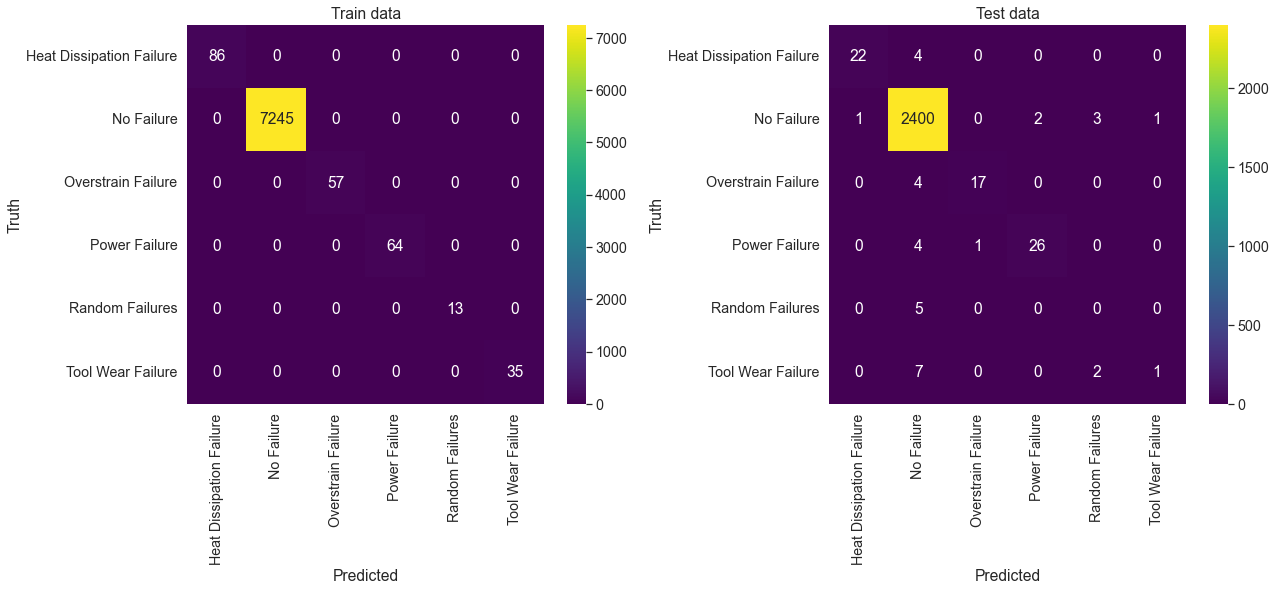

In [75]:
#Create the model
clf = GradientBoostingClassifier(n_estimators=200,max_depth=8).fit(X_train,y_train)
#Predict train and test
y_tilde = clf.predict(X_train)
y_pred =clf.predict(X_test)
#Confusion matrix
cm_train = confusion_matrix(y_train, y_tilde)
cm_test = confusion_matrix(y_test, y_pred)
indexes = np.append(clf.classes_,['Macro averaged','Micro averaged'])
metrics = ['Accuracy','Precision','Recall','F1-score','Support(n samples)']
#Display the scores
print("Train data")
display(scores(y_train,y_tilde,indexes,metrics))
print("\nTest data")
display(scores(y_test,y_pred,indexes,metrics))
#Plotting the confusion matrices
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
fig.tight_layout()
fig.tight_layout(pad=10.0)
ax1 = plot_confusion_matrix(conf_mat = cm_train,ax=ax1,title = 'Train data',labels=clf.classes_)
ax2 = plot_confusion_matrix(conf_mat = cm_test,ax=ax2,title = 'Test data',labels=clf.classes_)

In [76]:
[est.get_depth() for est in clf.estimators_]

AttributeError: 'numpy.ndarray' object has no attribute 'get_depth'

In [77]:
#Root node of the trees
nodes = 5 #Number of nodes to display
#Display dataframe of features at the different nodes of each tree
display(pd.DataFrame(np.asarray([[X.columns[est.tree_.feature[i]] for i in range(nodes)] for est in clf.estimators_]),
                     columns=['node {0}'.format(i) for i in range(nodes)]))

AttributeError: 'numpy.ndarray' object has no attribute 'tree_'

{'max_depth': 6, 'n_estimators': 101}


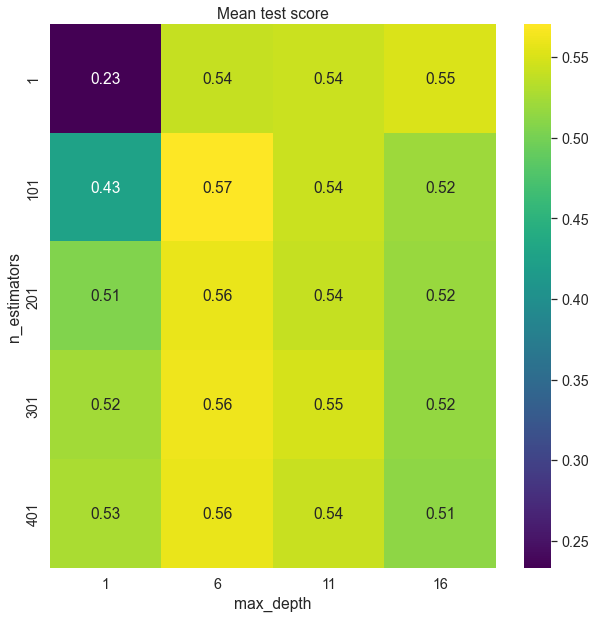

In [79]:
clf = GradientBoostingClassifier()
estimators = range(1,500,100)
depths = np.arange(1,20,5)

params = {'n_estimators':estimators,
          'max_depth':depths}

gs, res = grid_search_df(X_train,y_train,clf,params,'f1_macro')
print(gs.best_params_)
plot_grid_search(res,('n_estimators','max_depth'))

#### Bias variance

<AxesSubplot:title={'center':'Variance'}>

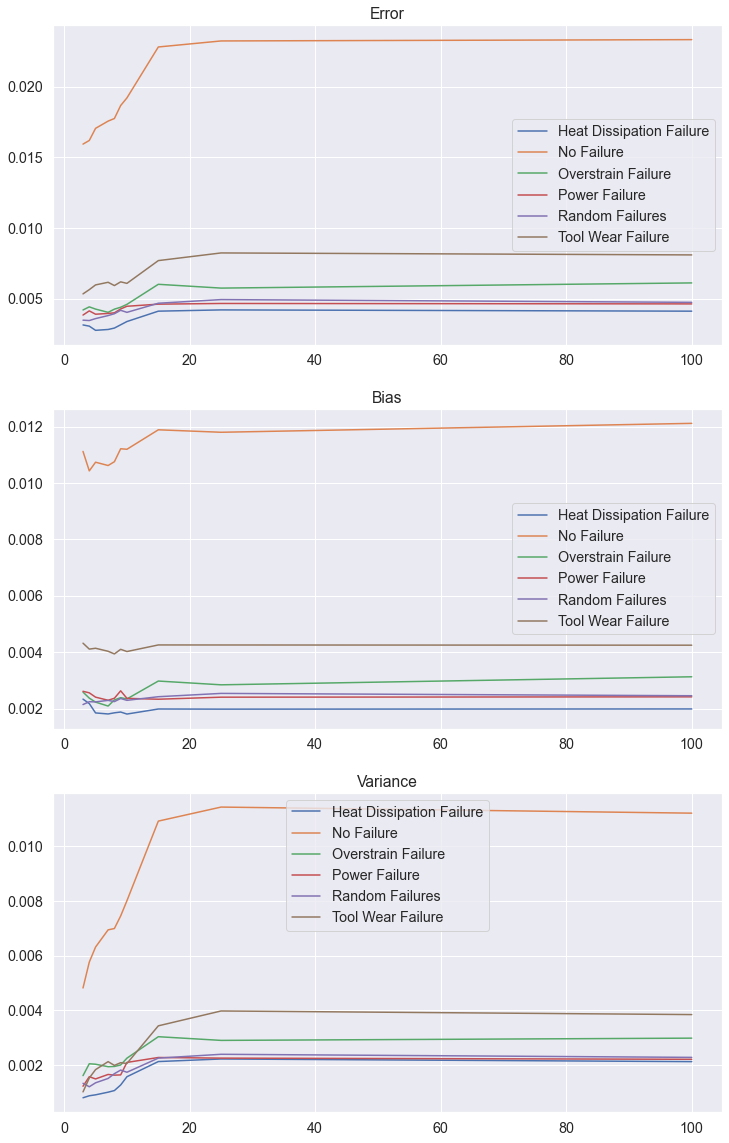

In [115]:
clf = GradientBoostingClassifier(n_estimators=100,max_depth=6)
#Tree depths to test
complexity = {'max_depth':[3,4,5,7,8,9,10,15,25,100]}
#Calculating bias variance on all complexity params
err,bi,var = bias_var_analysis(clf,X_train, X_test, y_train,y_test,complexity,100)
#Creating data frames
err_df = pd.DataFrame(err,columns=clf.classes_,index=list(complexity.values())[0])
bi_df = pd.DataFrame(bi,columns=clf.classes_,index=list(complexity.values())[0])
var_df = pd.DataFrame(var,columns=clf.classes_,index=list(complexity.values())[0])
#Plotting
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (12,20))
err_df.plot(title='Error',ax=ax1)
bi_df.plot(title='Bias',ax=ax2)
var_df.plot(title='Variance',ax=ax3)

<AxesSubplot:title={'center':'Bias Variance for complete model'}>

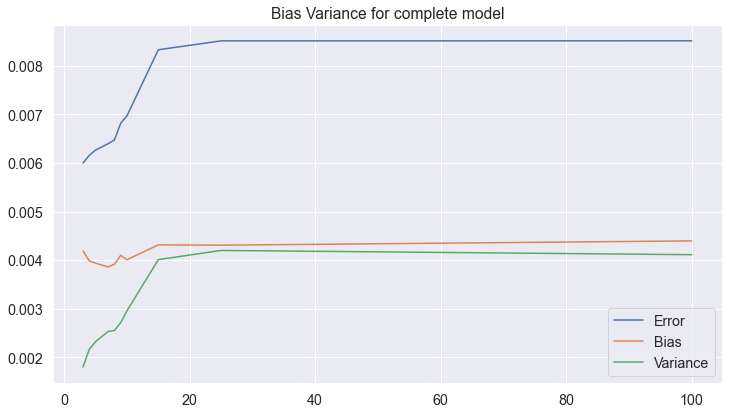

In [116]:
fig, ax1 = plt.subplots(1,1,figsize = (12,6.6))
pd.DataFrame(np.column_stack([np.mean(err,axis=1),np.mean(bi,axis=1),np.mean(var,axis=1)]),
             columns=['Error','Bias','Variance'],
             index=list(complexity.values())[0]).plot(title='Bias Variance for complete model',ax=ax1)

### Benchmarking

Train data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,1.0,1.0,1.0,1.0,86.0
No Failure,1.0,1.0,1.0,1.0,7245.0
Overstrain Failure,1.0,1.0,1.0,1.0,57.0
Power Failure,1.0,1.0,1.0,1.0,64.0
Random Failures,1.0,1.0,1.0,1.0,13.0
Tool Wear Failure,1.0,1.0,1.0,1.0,35.0
Macro averaged,1.0,1.0,1.0,1.0,None
Micro averaged,1.0,1.0,1.0,1.0,None



Test data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,0.884615,0.920000,0.884615,0.901961,26.0
No Failure,0.995015,0.987629,0.995015,0.991308,2407.0
Overstrain Failure,0.714286,0.833333,0.714286,0.769231,21.0
Power Failure,0.709677,0.916667,0.709677,0.800000,31.0
Random Failures,0.000000,0.000000,0.000000,0.000000,5.0
Tool Wear Failure,0.000000,0.000000,0.000000,0.000000,10.0
Macro averaged,0.550599,0.609605,0.550599,0.577083,None
Micro averaged,0.982000,0.982000,0.982000,0.982000,None


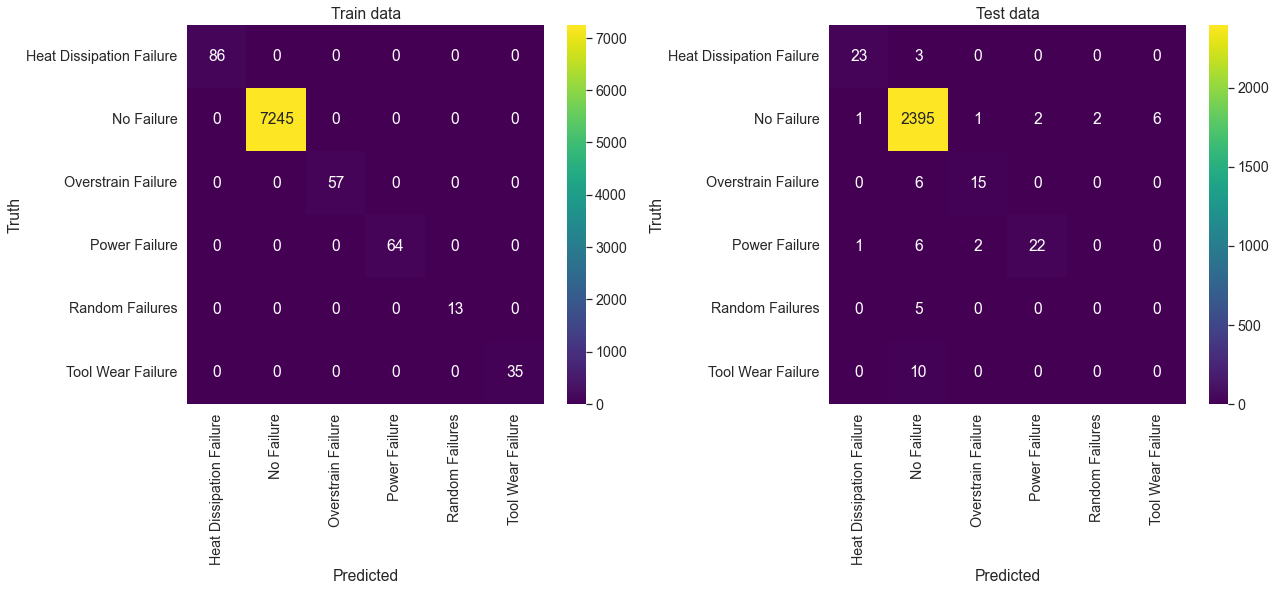

In [144]:
#Create the model
#use DecisionTreeClassifier() as base estimator in BaggingClassifier and fit
clf = GradientBoostingClassifier(n_estimators=100,max_depth=6).fit(X_train,y_train)
#Predict train and test
y_tilde = clf.predict(X_train)
y_pred =clf.predict(X_test)
#Confusion matrix
cm_train = confusion_matrix(y_train, y_tilde)
cm_test = confusion_matrix(y_test, y_pred)
indexes = np.append(clf.classes_,['Macro averaged','Micro averaged'])
metrics = ['Accuracy','Precision','Recall','F1-score','Support(n samples)']
#Display the scores
print("Train data")
display(scores(y_train,y_tilde,indexes,metrics))
print("\nTest data")
display(scores(y_test,y_pred,indexes,metrics))
#Plotting the confusion matrices
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
fig.tight_layout()
fig.tight_layout(pad=10.0)
ax1 = plot_confusion_matrix(conf_mat = cm_train,ax=ax1,title = 'Train data',labels=clf.classes_)
ax2 = plot_confusion_matrix(conf_mat = cm_test,ax=ax2,title = 'Test data',labels=clf.classes_)

In [82]:
clf = GradientBoostingClassifier(n_estimators=100,max_depth=6)
#Must use a stratified kfold due to class imbalance
cvs = StratifiedKFold(shuffle=True,n_splits=4)
#Cross validating f1 score
dt1_f1 = np.mean(cross_val_score(clf,X,y_m,scoring='f1_macro',n_jobs=-1,cv=cvs))
dt1_recall = np.mean(cross_val_score(clf,X,y_m,scoring='recall_macro',n_jobs=-1,cv=cvs))
dt1_precision = np.mean(cross_val_score(clf,X,y_m,scoring='precision_macro',n_jobs=-1,cv=cvs))
print('Cross validated F1 score: \t\t',dt1_f1)
print('Cross validated recall score: \t\t',dt1_recall)
print('Cross validated precision score: \t',dt1_precision)

Cross validated F1 score: 		 0.5694105175085923
Cross validated recall score: 		 0.5629823043787147
Cross validated precision score: 	 0.6198227552640048


# XGBoost

c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:26:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,1.0,1.0,1.0,1.0,86.0
No Failure,1.0,1.0,1.0,1.0,7245.0
Overstrain Failure,1.0,1.0,1.0,1.0,57.0
Power Failure,1.0,1.0,1.0,1.0,64.0
Random Failures,1.0,1.0,1.0,1.0,13.0
Tool Wear Failure,1.0,1.0,1.0,1.0,35.0
Macro averaged,1.0,1.0,1.0,1.0,None
Micro averaged,1.0,1.0,1.0,1.0,None



Test data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,0.884615,0.884615,0.884615,0.884615,26.0
No Failure,0.997923,0.989699,0.997923,0.993794,2407.0
Overstrain Failure,0.809524,0.850000,0.809524,0.829268,21.0
Power Failure,0.741935,0.958333,0.741935,0.836364,31.0
Random Failures,0.000000,0.000000,0.000000,0.000000,5.0
Tool Wear Failure,0.000000,0.000000,0.000000,0.000000,10.0
Macro averaged,0.572333,0.613775,0.572333,0.590674,None
Micro averaged,0.986000,0.986000,0.986000,0.986000,None


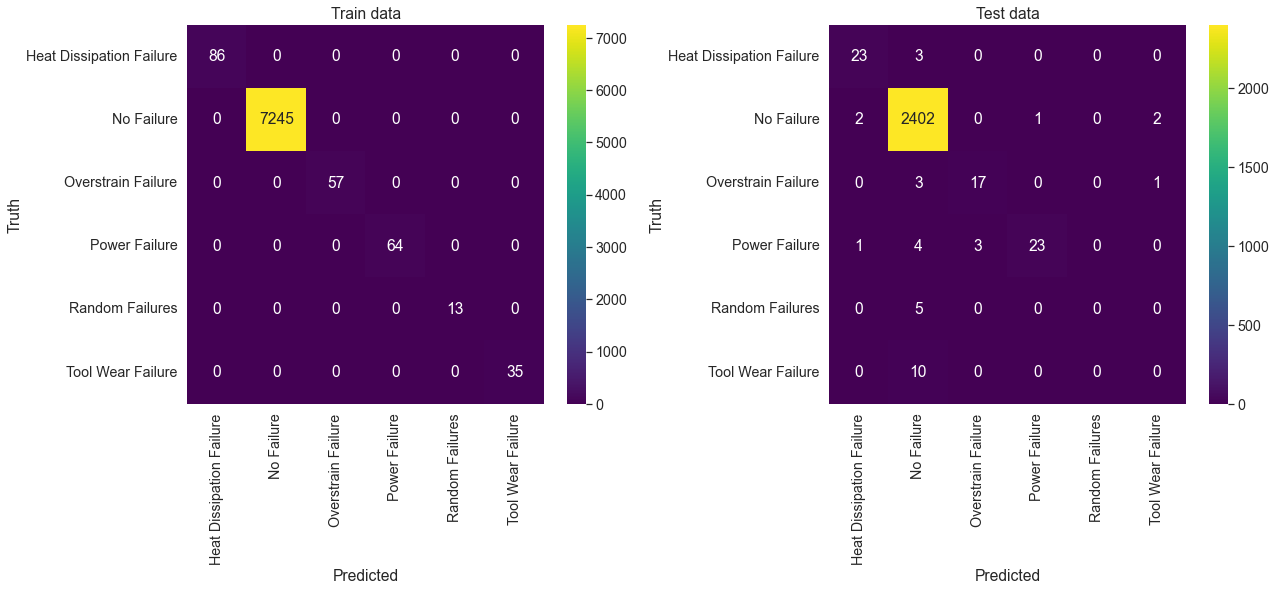

In [83]:
#Create the model
tree_clf = DecisionTreeClassifier()
#use tree_clf in BaggingClassifier and fit
clf =  xgb.XGBClassifier(n_estimators=700,max_depth=5,use_label_encoder=True, learning_rate=0.5).fit(X_train.to_numpy(),y_train)
#Predict train and test
y_tilde = clf.predict(X_train.to_numpy())
y_pred =clf.predict(X_test.to_numpy())
#Confusion matrix
cm_train = confusion_matrix(y_train, y_tilde)
cm_test = confusion_matrix(y_test, y_pred)
indexes = np.append(clf.classes_,['Macro averaged','Micro averaged'])
metrics = ['Accuracy','Precision','Recall','F1-score','Support(n samples)']
#Display the scores
print("Train data")
display(scores(y_train,y_tilde,indexes,metrics))
print("\nTest data")
display(scores(y_test,y_pred,indexes,metrics))
#Plotting the confusion matrices
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
fig.tight_layout()
fig.tight_layout(pad=10.0)
ax1 = plot_confusion_matrix(conf_mat = cm_train,ax=ax1,title = 'Train data',labels=clf.classes_)
ax2 = plot_confusion_matrix(conf_mat = cm_test,ax=ax2,title = 'Test data',labels=clf.classes_)

All models seem to struggle heavy with tool wear failure. Random Failures does make sense, though tool wear failure should exhibit some sort of pattern. Perhaps the pattern in tool wear is more temporal dependent than the other failure types, i.e. that 

c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.1, 'n_estimators': 901}


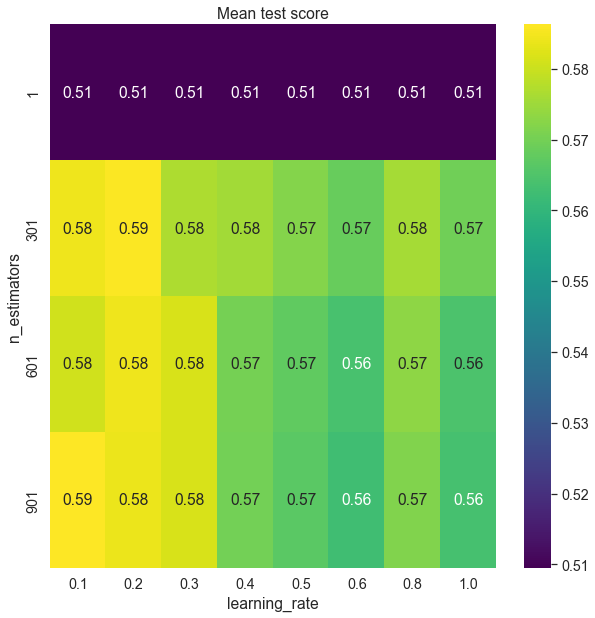

In [86]:
clf =  xgb.XGBClassifier(n_estimators=700,max_depth=5,use_label_encoder=True, learning_rate=0.5)
estimators = range(1,1000,300)
lrs = [0.1,0.2,0.3,0.4,0.5,0.6,0.8,1]

params = {'n_estimators':estimators,
          'learning_rate':lrs}

gs, res = grid_search_df(X_train.to_numpy(),y_train.to_numpy(),clf,params,'f1_macro')
print(gs.best_params_)
plot_grid_search(res,('n_estimators','learning_rate'))

#### Bias Variance

<AxesSubplot:title={'center':'Variance'}>

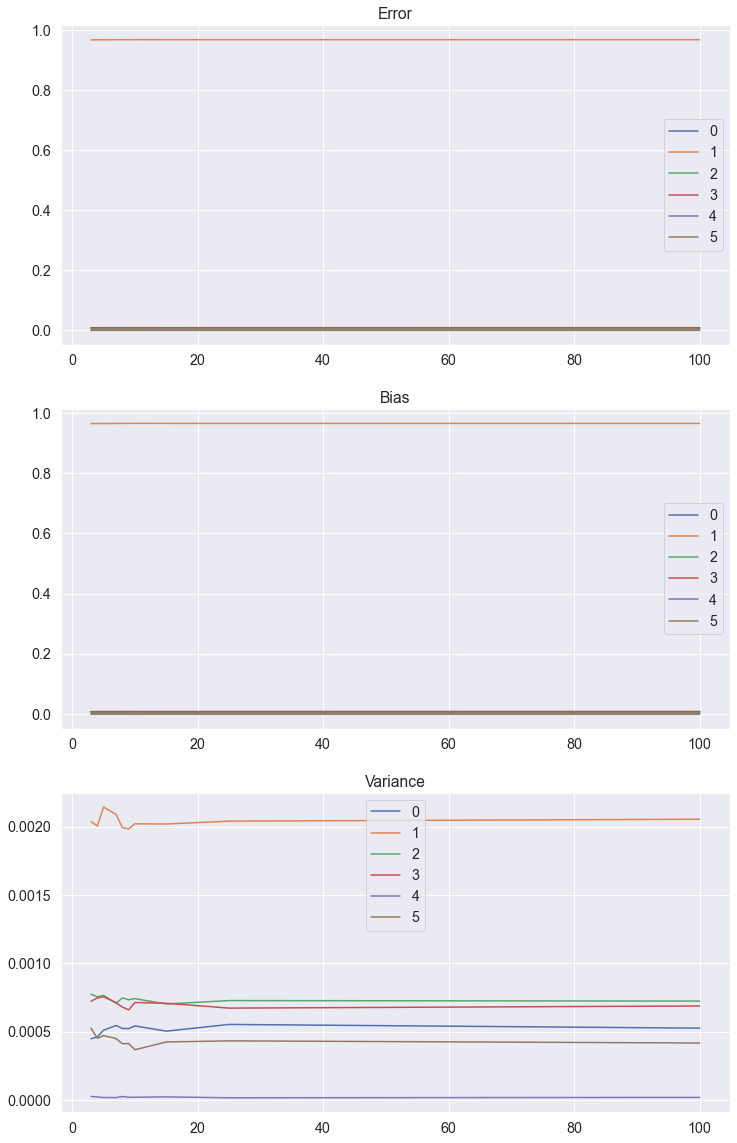

In [117]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder().fit(y_m)

clf =  xgb.XGBClassifier(n_estimators=900,max_depth=5,use_label_encoder=False, learning_rate=0.1,verbosity=0,n_jobs=-1)
#Tree depths to test
complexity = {'max_depth':[3,4,5,7,8,9,10,15,25,100]}
#Calculating bias variance on all complexity params
err,bi,var = bias_var_analysis(clf,X_train.to_numpy(), X_test.to_numpy(), enc.transform(y_train),y_test,complexity,100)
#Creating data frames
err_df = pd.DataFrame(err,columns=clf.classes_,index=list(complexity.values())[0])
bi_df = pd.DataFrame(bi,columns=clf.classes_,index=list(complexity.values())[0])
var_df = pd.DataFrame(var,columns=clf.classes_,index=list(complexity.values())[0])
#Plotting
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (12,20))
err_df.plot(title='Error',ax=ax1)
bi_df.plot(title='Bias',ax=ax2)
var_df.plot(title='Variance',ax=ax3)

<AxesSubplot:title={'center':'Bias Variance for complete model'}>

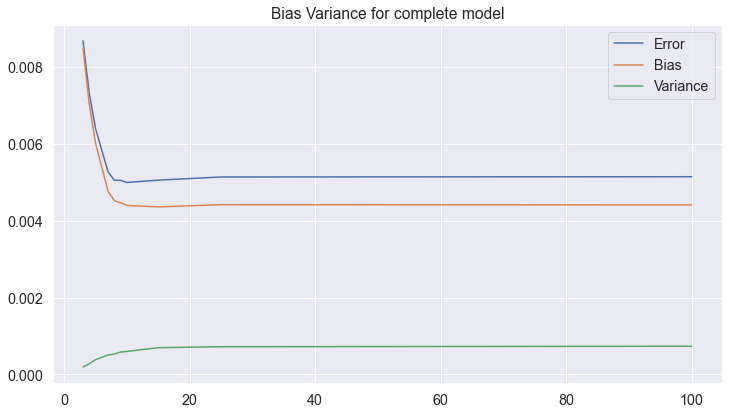

In [105]:
fig, ax1 = plt.subplots(1,1,figsize = (12,6.6))
pd.DataFrame(np.column_stack([np.mean(err,axis=1),np.mean(bi,axis=1),np.mean(var,axis=1)]),
             columns=['Error','Bias','Variance'],
             index=list(complexity.values())[0]).plot(title='Bias Variance for complete model',ax=ax1)

### Benchmark

c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Train data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,1.0,1.0,1.0,1.0,86.0
No Failure,1.0,1.0,1.0,1.0,7245.0
Overstrain Failure,1.0,1.0,1.0,1.0,57.0
Power Failure,1.0,1.0,1.0,1.0,64.0
Random Failures,1.0,1.0,1.0,1.0,13.0
Tool Wear Failure,1.0,1.0,1.0,1.0,35.0
Macro averaged,1.0,1.0,1.0,1.0,None
Micro averaged,1.0,1.0,1.0,1.0,None



Test data


,Accuracy,Precision,Recall,F1-score,Support(n samples)
Heat Dissipation Failure,0.884615,0.851852,0.884615,0.867925,26.0
No Failure,0.996676,0.989278,0.996676,0.992964,2407.0
Overstrain Failure,0.761905,0.800000,0.761905,0.780488,21.0
Power Failure,0.741935,0.958333,0.741935,0.836364,31.0
Random Failures,0.000000,0.000000,0.000000,0.000000,5.0
Tool Wear Failure,0.000000,0.000000,0.000000,0.000000,10.0
Macro averaged,0.564189,0.599911,0.564189,0.579623,None
Micro averaged,0.984400,0.984400,0.984400,0.984400,None


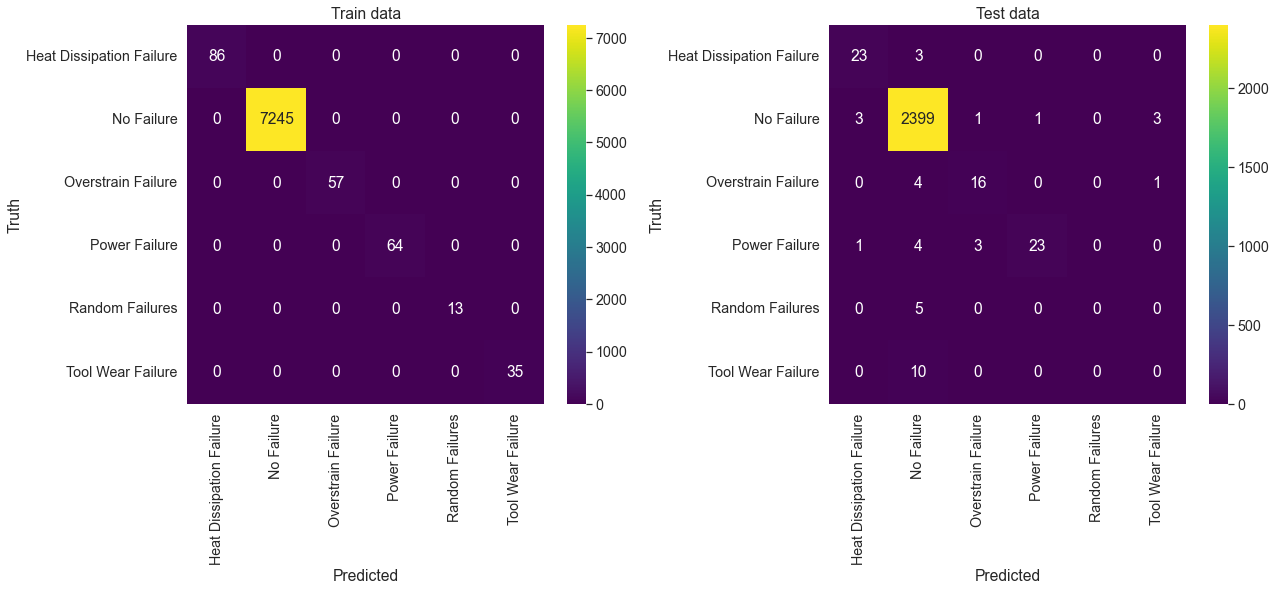

In [146]:
#Create the model
#use DecisionTreeClassifier() as base estimator in BaggingClassifier and fit
clf =  xgb.XGBClassifier(n_estimators=900,max_depth=5,use_label_encoder=True, learning_rate=0.1).fit(X_train.to_numpy(),y_train.to_numpy())
#Predict train and test
y_tilde = clf.predict(X_train.to_numpy())
y_pred =clf.predict(X_test.to_numpy())
#Confusion matrix
cm_train = confusion_matrix(y_train, y_tilde)
cm_test = confusion_matrix(y_test, y_pred)
indexes = np.append(clf.classes_,['Macro averaged','Micro averaged'])
metrics = ['Accuracy','Precision','Recall','F1-score','Support(n samples)']
#Display the scores
print("Train data")
display(scores(y_train,y_tilde,indexes,metrics))
print("\nTest data")
display(scores(y_test,y_pred,indexes,metrics))
#Plotting the confusion matrices
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
fig.tight_layout()
fig.tight_layout(pad=10.0)
ax1 = plot_confusion_matrix(conf_mat = cm_train,ax=ax1,title = 'Train data',labels=clf.classes_)
ax2 = plot_confusion_matrix(conf_mat = cm_test,ax=ax2,title = 'Test data',labels=clf.classes_)

In [88]:
clf =  xgb.XGBClassifier(n_estimators=900,max_depth=5,use_label_encoder=True, learning_rate=0.1)
#Must use a stratified kfold due to class imbalance
cvs = StratifiedKFold(shuffle=True,n_splits=4)
#Cross validating f1 score
dt1_f1 = np.mean(cross_val_score(clf,X.to_numpy(),y_m.to_numpy(),scoring='f1_macro',n_jobs=-1,cv=cvs))
dt1_recall = np.mean(cross_val_score(clf,X.to_numpy(),y_m.to_numpy(),scoring='recall_macro',n_jobs=-1,cv=cvs))
dt1_precision = np.mean(cross_val_score(clf,X.to_numpy(),y_m.to_numpy(),scoring='precision_macro',n_jobs=-1,cv=cvs))
print('Cross validated F1 score: \t\t',dt1_f1)
print('Cross validated recall score: \t\t',dt1_recall)
print('Cross validated precision score: \t',dt1_precision)

Cross validated F1 score: 		 0.6023873512479241
Cross validated recall score: 		 0.5803692466560829
Cross validated precision score: 	 0.6349229280951467
